## Importación de Librerías ##

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
from keras.models import load_model
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, auc
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU
# from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler, SMOTE
import shap
import joblib

warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Configurado para utilizar la GPU.")
    except:
        print("Error al configurar el crecimiento de memoria en la GPU.")

# Muestra la información sobre los dispositivos disponibles
print(tf.config.list_physical_devices())

# Muestra el nombre de la GPU si está disponible
if tf.test.gpu_device_name():
    print(f"GPU encontrada: {tf.test.gpu_device_name()}")
else:
    print("No se encontró GPU. Cambiando a la CPU.")
    tf.config.set_visible_devices([], 'GPU')  # Forzar el uso de la CPU

# Verificar que TensorFlow esté utilizando la GPU o la CPU
print("Dispositivo actual:", tf.config.list_logical_devices()[0].device_type)

Configurado para utilizar la GPU.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU encontrada: /device:GPU:0
Dispositivo actual: CPU


# Lectura de los datos y solución de valores nulos #

In [6]:
df = pd.read_csv('files/weatherAUS.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145407  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145408  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145409  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145410  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145411  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
0            NaN           W           44.0          W  ...        22.0   
1            NaN         WNW           44.0        NNW  ...        25.0   
2            NaN         WSW           46.0          W  ...        30.0   
3            NaN          NE           24.0         SE  ...        16.0   
4            NaN           W           41.0        ENE  ...        33.0   
...          ...         ...            ...        ...  ...         ...   
145407       NaN           E           31.0        ESE  ...        27.0   
145408       NaN           E           31.0         SE  ...        24.0   
145409       NaN         NNW           22.0         SE  ...        21.0   
145410       NaN           N           37.0         SE  ...        24.0   
145411       NaN          SE           28.0        SSE  ...        24.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1       8.0       NaN     16.9     21.8   
1            1010.6       1007.8       NaN       NaN     17.2     24.3   
2            1007.6       1008.7       NaN       2.0     21.0     23.2   
3            1017.6       1012.8       NaN       NaN     18.1     26.5   
4            1010.8       1006.0       7.0       8.0     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
145407       1024.7       1021.2       NaN       NaN      9.4     20.9   
145408       1024.6       1020.3       NaN       NaN     10.1     22.4   
145409       1023.5       1019.1       NaN       NaN     10.9     24.5   
145410       1021.0       1016.8       NaN       NaN     12.5     26.1   
145411       1019.4       1016.5       3.0       2.0     15.1     26.0   

        RainToday  RainTomorrow  RainfallTomorrow  
0              No            No               0.0  
1              No            No               0.0  
2              No            No               0.0  
3              No            No               1.0  
4              No            No               0.2  
...           ...           ...               ...  
145407         No            No               0.0  
145408         No            No               0.0  
145409         No            No               0.0  
145410         No            No               0.0  
145411         No            No               0.0  

[145412 rows x 24 columns]

In [7]:
vacios_original=df.isna().sum()
vacios_original

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

## Clustering ##

Para solventar el problema de los datos vacíos decimos agrupar las ciudades en distintos clusters y completar aquellos datos vacíos con datos del mismo cluster para la misma fecha.

  File "c:\Users\guido\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


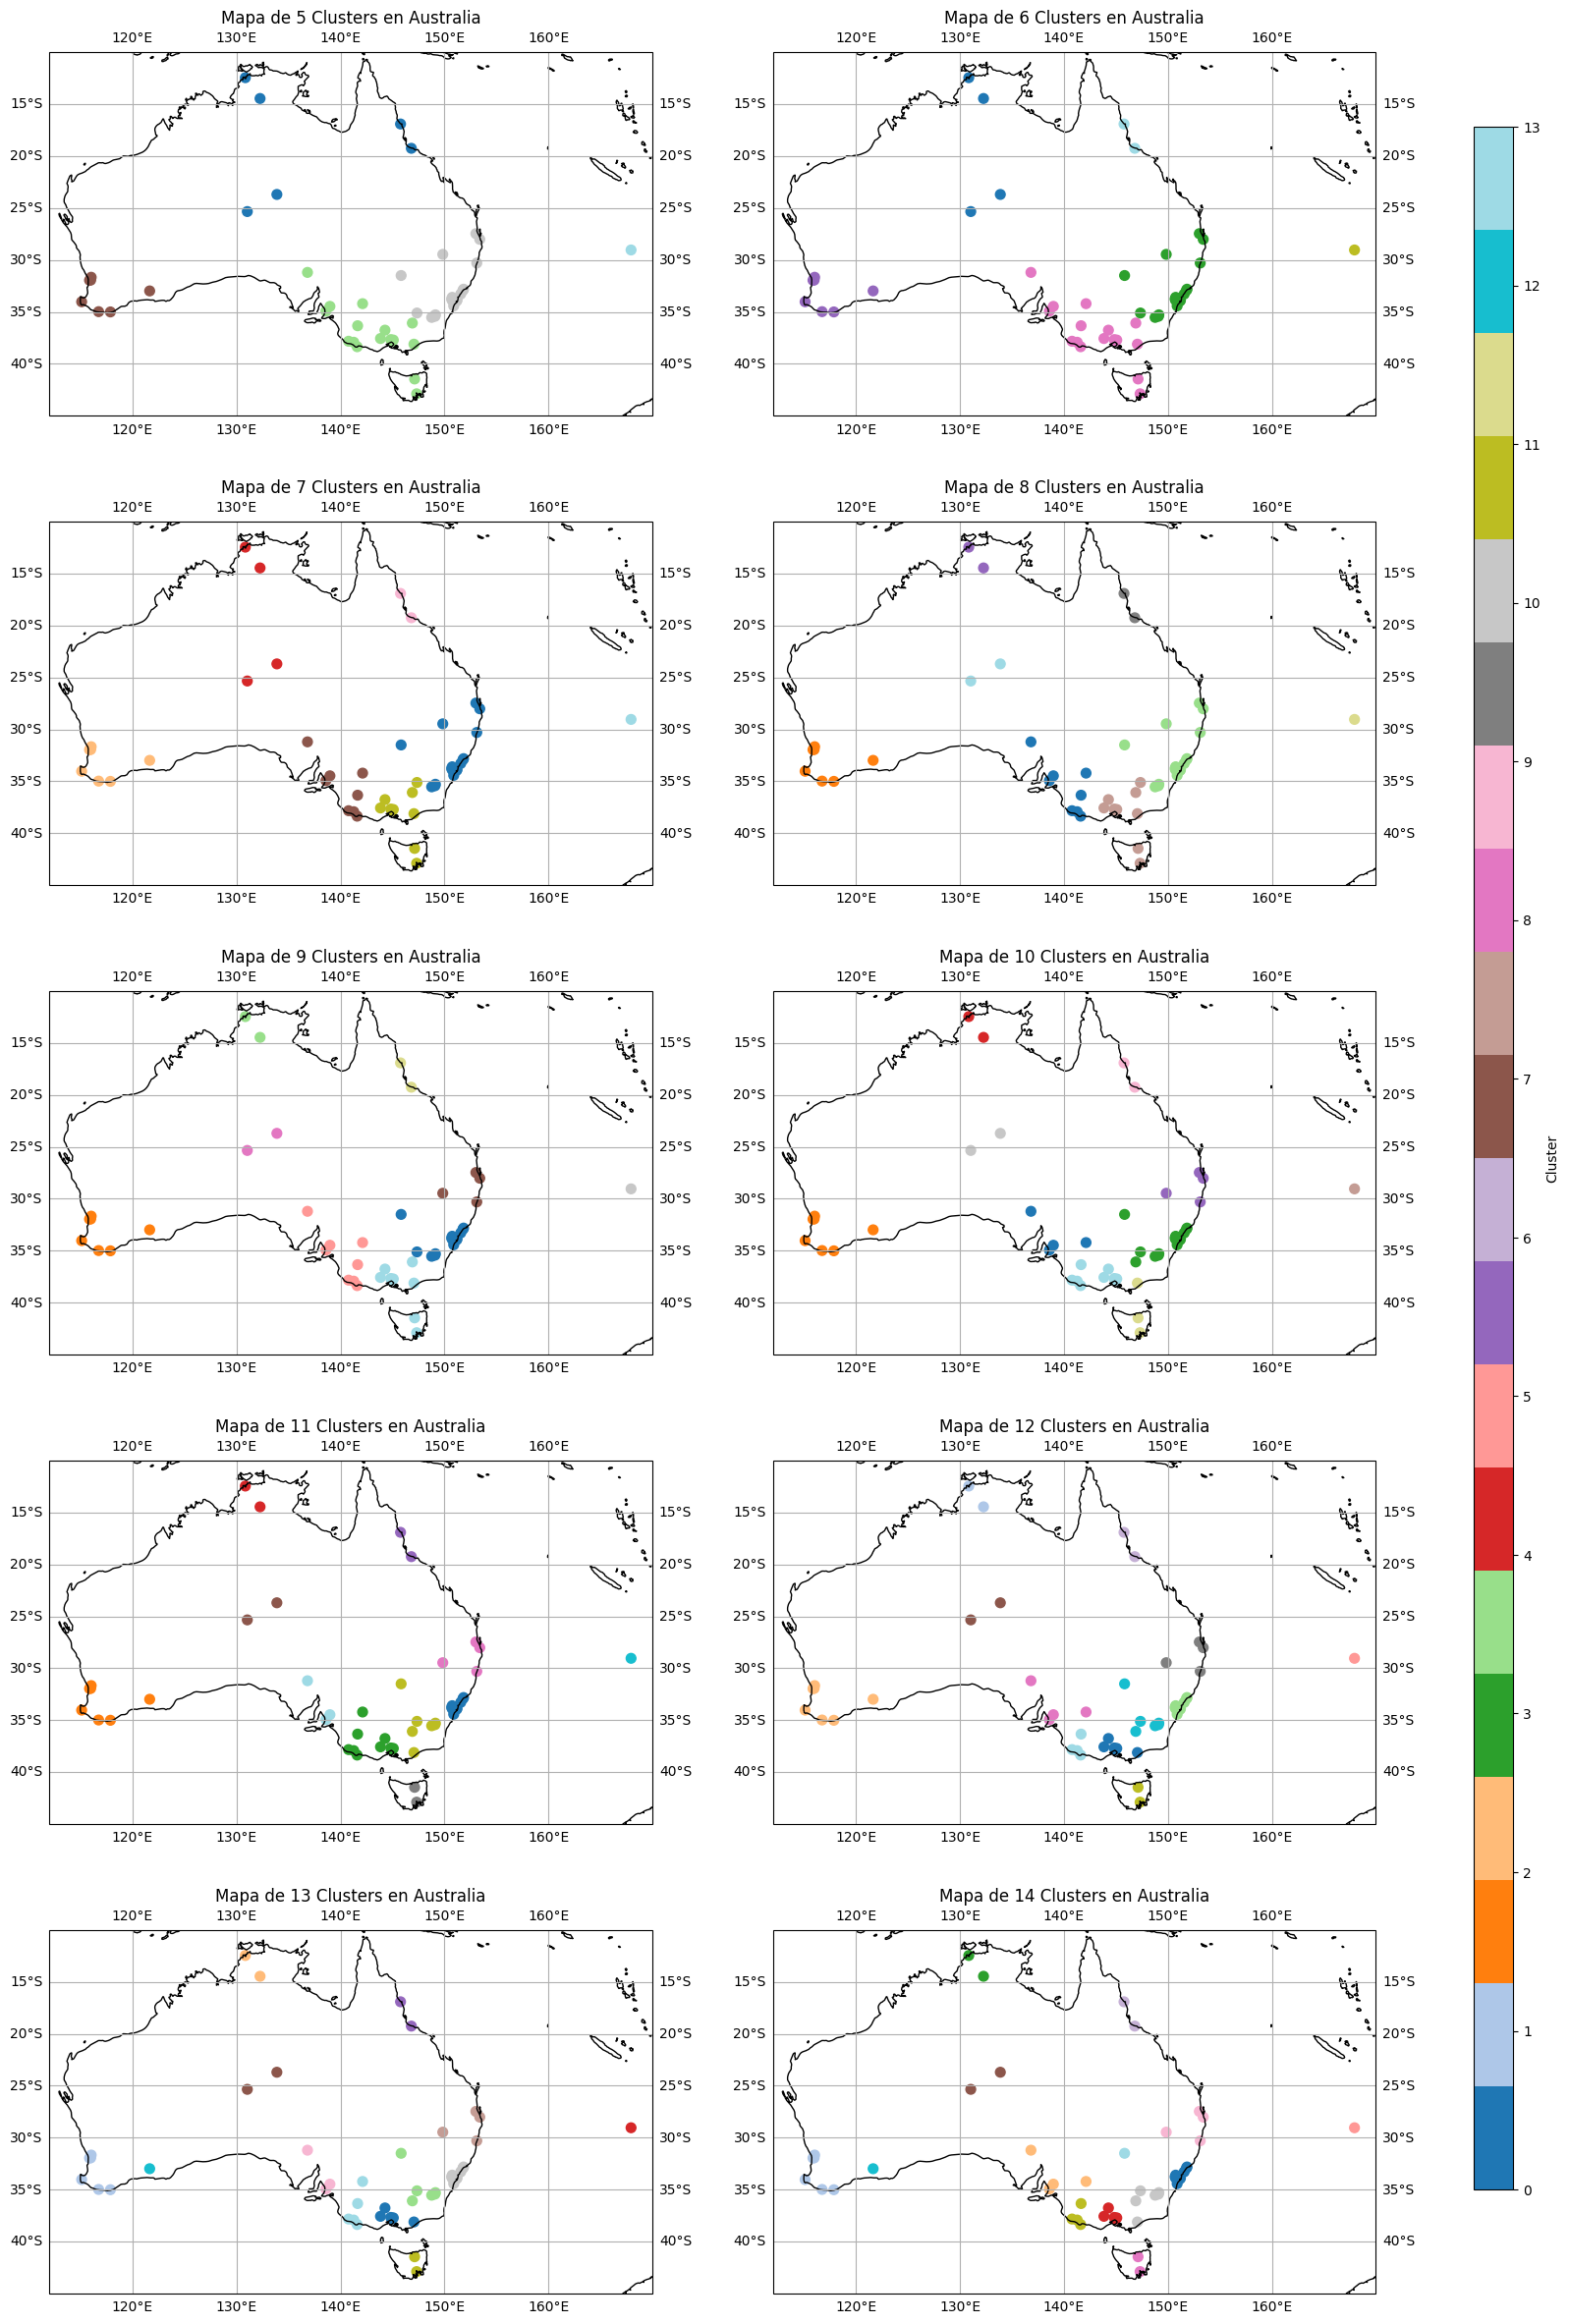

In [8]:
cities=df['Location'].unique().copy()
cities_coord = {'Adelaide': (-34.9285, 138.6007),
                'Albany': (-35.0031, 117.8657),
                'Albury': (-36.0737, 146.9135),
                'AliceSprings': (-23.6980, 133.8807),
                'BadgerysCreek': (-33.8813, 150.7400),
                'Ballarat': (-37.5622, 143.8503),
                'Bendigo': (-36.7570, 144.2794),
                'Brisbane': (-27.4698, 153.0251),
                'Cairns': (-16.9186, 145.7781),
                'Canberra': (-35.2809, 149.1300),
                'Cobar': (-31.4983, 145.8344),
                'CoffsHarbour': (-30.2963, 153.1131),
                'Dartmoor': (-37.9223, 141.2760),
                'Darwin': (-12.4634, 130.8456),
                'GoldCoast': (-28.0167, 153.4000),
                'Hobart': (-42.8821, 147.3272),
                'Katherine': (-14.4644, 132.2630),
                'Launceston': (-41.4545, 147.1317),
                'Melbourne': (-37.8136, 144.9631),
                'MelbourneAirport': (-37.6690, 144.8410),
                'Mildura': (-34.2083, 142.1270),
                'Moree': (-29.4638, 149.8413),
                'MountGambier': (-37.8241, 140.7798),
                'MountGinini': (-35.5294, 148.7720),
                'Newcastle': (-32.9283, 151.7817),
                'Nhil': (-36.3328, 141.6503),
                'NorahHead': (-33.2833, 151.5667),
                'NorfolkIsland': (-29.0408, 167.9547),
                'Nuriootpa': (-34.4667, 138.9833),
                'PearceRAAF': (-31.6675, 116.0158),
                'Penrith': (-33.7581, 150.6950),
                'Perth': (-31.9522, 115.8589),
                'PerthAirport': (-31.9405, 115.9660),
                'Portland': (-38.3511, 141.6056),
                'Richmond': (-33.6000, 150.7500),
                'Sale': (-38.1063, 147.0674),
                'SalmonGums': (-32.9819, 121.6431),
                'Sydney': (-33.8688, 151.2093),
                'SydneyAirport': (-33.9461, 151.1772),
                'Townsville': (-19.2583, 146.8169),
                'Tuggeranong': (-35.4244, 149.0887),
                'Uluru': (-25.3444, 131.0369),
                'WaggaWagga': (-35.1082, 147.3598),
                'Walpole': (-34.9772, 116.7317),
                'Watsonia': (-37.7114, 145.0831),
                'Williamtown': (-32.8150, 151.8428),
                'Witchcliffe': (-34.0264, 115.1000),
                'Wollongong': (-34.4241, 150.8931),
                'Woomera': (-31.1997, 136.8256)}

cities_coord = pd.DataFrame.from_dict(cities_coord, orient='index', columns=['lat', 'lon'])
cities_coord['mean_rain'] = df.groupby('Location')['Rainfall'].mean()
xPos=cities_coord[['lat','lon','mean_rain']].copy()
Nc= range(1, 20)
kmeans= [KMeans(n_clusters=i, n_init=10) for i in Nc]
score = [kmeans[i].fit(xPos).score(xPos) for i in range(len(kmeans))]

num_clusters = range(5, 15)
num_rows = len(num_clusters) // 2 + len(num_clusters) % 2
fig, axes = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows), subplot_kw={'projection': ccrs.PlateCarree()})

for i, num_cluster in enumerate(num_clusters):
    # Elegir el número óptimo de clusters
    kmeans = KMeans(n_clusters=num_cluster, n_init=10).fit(xPos[['lon', 'lat']])
    centroids = kmeans.cluster_centers_

    # Asignar cada punto a su respectivo cluster
    xPos['cluster'] = kmeans.predict(xPos[['lon', 'lat']])
    labels = np.unique(xPos['cluster'])
    palette = sns.color_palette("tab20", len(labels))
    xPos['cluster'] = xPos['cluster'].astype('category')

    # Calcular la fila y la columna actual
    row = i // 2
    col = i % 2

    # Crear un mapa de Australia para el subplot actual
    ax = axes[row, col]
    ax.set_extent([112, 170, -45, -10], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Crear un gráfico de dispersión centrado en Australia
    scatter = ax.scatter(
        xPos['lon'], xPos['lat'],
        c=xPos['cluster'], cmap='tab20', s=50,
        transform=ccrs.PlateCarree()
    )

    # Configurar título y leyenda para el subplot
    ax.set_title(f'Mapa de {num_cluster} Clusters en Australia')

# Eliminar subplots vacíos si es necesario
if len(num_clusters) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

# Añadir una barra de color común para todos los subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=labels, label='Cluster')

plt.show()

Decidimos utilizar 13 clusters debido a que consideramos es la cantidad que mejor se ajusta a los datos sin hacer overfitting.

In [9]:
# Elegir el número óptimo de clusters
kmeans = KMeans(n_clusters=13, n_init=10).fit(xPos)
centroids = kmeans.cluster_centers_

# Asignar cada punto a su respectivo cluster
xPos['cluster'] = kmeans.predict(xPos)
labels = np.unique(xPos['cluster'])
palette = sns.color_palette("hot", len(labels))
xPos['cluster'] = xPos['cluster'].astype('category')

df['Cluster']=df['Location'].map(xPos['cluster'])
df['Cluster']=pd.Categorical(df['Cluster'])
df.to_csv('files/weatherAUS_cluster.csv', index=False)

## Corrigiendo datos vacíos ##

Dado que estamos hablando de variables climáticas y se puede considerar que estan no presentan grandes variaciones para regiones cercanas, al clusterizar las ciudades podemos estimar aquellos datos vacíos como la media de los datos de las ciudades del mismo cluster para la misma fecha.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Date              145412 non-null  object  
 1   Location          145412 non-null  object  
 2   MinTemp           143928 non-null  float64 
 3   MaxTemp           144159 non-null  float64 
 4   Rainfall          142152 non-null  float64 
 5   Evaporation       82658 non-null   float64 
 6   Sunshine          75616 non-null   float64 
 7   WindGustDir       135096 non-null  object  
 8   WindGustSpeed     135159 non-null  float64 
 9   WindDir9am        134850 non-null  object  
 10  WindDir3pm        141186 non-null  object  
 11  WindSpeed9am      143645 non-null  float64 
 12  WindSpeed3pm      142351 non-null  float64 
 13  Humidity9am       142759 non-null  float64 
 14  Humidity3pm       140907 non-null  float64 
 15  Pressure9am       130351 non-null  float64 
 16  Pr

In [11]:
numeric_columns = df.select_dtypes(include=[float, int]).columns
non_numeric_columns = df.select_dtypes(include=[object]).columns

In [12]:
if os.path.exists('files/weatherAUS_corregido.csv'):
    df = pd.read_csv('files/weatherAUS_corregido.csv')
else:
    df['Date'] = pd.to_datetime(df['Date'])

    # Agrupa por 'Cluster' y 'Date' y llena los valores nulos con la media del grupo.
    grouped = df.groupby(['Cluster', 'Date'])
    df_filled = grouped[numeric_columns].transform(lambda x: x.fillna(x.mean()))

    df[numeric_columns] = df_filled

    # Función para llenar los valores nulos con la moda
    def fill_with_mode(x):
        mode_value = x.mode()
        if len(mode_value) > 0:
            return x.fillna(mode_value.iloc[0])
        else:
            return x

    # Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la moda del grupo
    df_non_numeric = df.groupby(['Cluster', 'Date'])[non_numeric_columns].transform(fill_with_mode)

    # Asignar los valores llenos al DataFrame original
    df[non_numeric_columns] = df_non_numeric

    df.to_csv('files/weatherAUS_corregido.csv', index=False)

In [13]:
vacios_transformado=df.isna().sum()
comparison_df = pd.DataFrame({'vacios_antes': vacios_original, 'vacios_despues': vacios_transformado})
total_datos = len(df)
comparison_df['porcentaje recuperado'] = 100 * (1 - comparison_df['vacios_despues'] / comparison_df['vacios_antes'])
comparison_df['porcentaje recuperado'] = comparison_df['porcentaje recuperado'].apply(lambda x: f'{x:.2f}%')
comparison_df['porcentaje_completo'] = 100 * (1 - comparison_df['vacios_despues'] / total_datos)
comparison_df['porcentaje_completo'] = comparison_df['porcentaje_completo'].apply(lambda x: f'{x:.2f}%')


# Mostrar el DataFrame con la comparación
comparison_df

vacios_antes  vacios_despues porcentaje recuperado  \
Cloud3pm               59336.0            8017                86.49%   
Cloud9am               55870.0            6899                87.65%   
Cluster                    NaN               0                  nan%   
Date                       0.0               0                  nan%   
Evaporation            62754.0            4973                92.08%   
Humidity3pm             4505.0              45                99.00%   
Humidity9am             2653.0              45                98.30%   
Location                   0.0               0                  nan%   
MaxTemp                 1253.0              44                96.49%   
MinTemp                 1484.0              44                97.04%   
Pressure3pm            15024.0            3006                79.99%   
Pressure9am            15061.0            3011                80.01%   
RainToday               3260.0             112                96.56%   
RainTomorrow            3259.0             112                96.56%   
Rainfall                3260.0             112                96.56%   
RainfallTomorrow        3259.0             112                96.56%   
Sunshine               69796.0            8487                87.84%   
Temp3pm                 3607.0              42                98.84%   
Temp9am                 1766.0              42                97.62%   
WindDir3pm              4226.0              93                97.80%   
WindDir9am             10562.0             338                96.80%   
WindGustDir            10316.0             512                95.04%   
WindGustSpeed          10253.0             510                95.03%   
WindSpeed3pm            3061.0              79                97.42%   
WindSpeed9am            1767.0              89                94.96%   

                 porcentaje_completo  
Cloud3pm                      94.49%  
Cloud9am                      95.26%  
Cluster                      100.00%  
Date                         100.00%  
Evaporation                   96.58%  
Humidity3pm                   99.97%  
Humidity9am                   99.97%  
Location                     100.00%  
MaxTemp                       99.97%  
MinTemp                       99.97%  
Pressure3pm                   97.93%  
Pressure9am                   97.93%  
RainToday                     99.92%  
RainTomorrow                  99.92%  
Rainfall                      99.92%  
RainfallTomorrow              99.92%  
Sunshine                      94.16%  
Temp3pm                       99.97%  
Temp9am                       99.97%  
WindDir3pm                    99.94%  
WindDir9am                    99.77%  
WindGustDir                   99.65%  
WindGustSpeed                 99.65%  
WindSpeed3pm                  99.95%  
WindSpeed9am                  99.94%

Podemos notar que el método fue efectivo, habiendo recuperado grandes cantidades de datos y con registros totales completos que se acercan al 100%. Ahora podríamos considerar eliminar los registros que presenten valores nulos y no deberíamos perder grandes vólumenes de información.

In [14]:
df_sin_nan = df.dropna()
df_sin_nan.to_csv('files/weatherAUS_sin_nan.csv', index=False)
df=df_sin_nan.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132032 entries, 0 to 144987
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              132032 non-null  datetime64[ns]
 1   Location          132032 non-null  object        
 2   MinTemp           132032 non-null  float64       
 3   MaxTemp           132032 non-null  float64       
 4   Rainfall          132032 non-null  float64       
 5   Evaporation       132032 non-null  float64       
 6   Sunshine          132032 non-null  float64       
 7   WindGustDir       132032 non-null  object        
 8   WindGustSpeed     132032 non-null  float64       
 9   WindDir9am        132032 non-null  object        
 10  WindDir3pm        132032 non-null  object        
 11  WindSpeed9am      132032 non-null  float64       
 12  WindSpeed3pm      132032 non-null  float64       
 13  Humidity9am       132032 non-null  float64       
 14  Humidity3

## Unificando Variables relacionadas ##

Existen relaciones intrínsecas entre ciertas variables, para poder hacer predicciones con ellas decidimos unificarlas en otras nuevas. Construimos un vector para aquellas variables que presentaban módulo y dirección, para luego tomar sus componentes como nuevos parámetros. Tomamos la diferencia de presiones también como nueva variable, el mismo procedimiento lo hacemos para la humedad. Para las variables de nubosidad construimos una nueva variable categórica que representara el estado del cielo en ese día.

In [15]:
def vector_coordinates(df, column, dir, speed, threshold=1e-6):
    direcciones = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }
    velocidad = df[speed]
    df[column + 'u'] = -velocidad * np.sin(np.deg2rad(df[dir].map(direcciones)))
    df[column + 'v'] = -velocidad * np.cos(np.deg2rad(df[dir].map(direcciones)))
    
    # Comprobación condicional para valores cercanos a cero
    df[column + 'u'][np.abs(df[column + 'u']) < threshold] = 0
    df[column + 'v'][np.abs(df[column + 'v']) < threshold] = 0
    
    return df

def definir_estado_del_cielo(row):
    if row['Cloud9am'] == 0 and row['Cloud3pm'] == 0:
        return 'Despejado'
    elif row['Cloud9am'] <= 4 and row['Cloud3pm'] <= 4:
        return 'Parcialmente Nublado'
    elif row['Cloud9am'] <= 7 and row['Cloud3pm'] <= 7:
        return 'Nublado'
    else:
        return 'Muy Nublado'

In [16]:
df=vector_coordinates(df,'Wind9am','WindDir9am','WindSpeed9am')
df=vector_coordinates(df,'Wind3pm','WindDir3pm','WindSpeed3pm')
df=vector_coordinates(df,'WindGust','WindGustDir','WindGustSpeed')
df['Max_Pressure'] = df[['Pressure9am', 'Pressure3pm']].max(axis=1)
df['Min_Pressure'] = df[['Pressure9am', 'Pressure3pm']].min(axis=1)
df['Max_Humidity'] = df[['Humidity9am', 'Humidity3pm']].max(axis=1)
df['Min_Humidity'] = df[['Humidity9am', 'Humidity3pm']].min(axis=1)
df['Estado_Cielo'] = df.apply(definir_estado_del_cielo, axis=1)

df.drop(['Cloud3pm','Cloud9am','Humidity3pm','Humidity9am','WindSpeed9am','WindSpeed3pm','WindGustSpeed','WindDir9am','WindDir3pm','WindGustDir','Pressure3pm','Pressure9am','Temp3pm','Temp9am'], axis=1, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

In [17]:
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          9.6      13.0   
1      2008-12-02   Albury      7.4     25.1       0.0         13.0      13.2   
2      2008-12-03   Albury     12.9     25.7       0.0         10.2      13.2   
3      2008-12-04   Albury      9.2     28.0       0.0         11.0      10.8   
4      2008-12-05   Albury     17.5     32.3       1.0          6.6       8.1   
...           ...      ...      ...      ...       ...          ...       ...   
144981 2016-04-20    Uluru     18.8     31.7       0.0          8.0       9.9   
144984 2016-04-23    Uluru     16.9     28.4       0.0         18.4      11.0   
144985 2016-04-24    Uluru     12.1     27.3       0.0          8.2      11.0   
144986 2016-04-25    Uluru      9.6     28.8       0.0          7.8      11.0   
144987 2016-04-26    Uluru     11.0     32.5       0.0          8.0      11.0   

       RainToday RainTomorrow  RainfallTomorrow  ...   Wind9amv   Wind3pmu  \
0             No           No               0.0  ...   0.000000  22.173109   
1             No           No               0.0  ...  -3.695518  20.325350   
2             No           No               0.0  ...   0.000000  24.020868   
3             No           No               1.0  ...   7.778175  -9.000000   
4             No           No               0.2  ...  -2.678784  14.142136   
...          ...          ...               ...  ...        ...        ...   
144981        No           No               0.0  ...  17.000000 -13.435029   
144984        No           No               0.0  ...   7.653669 -18.477591   
144985        No           No               0.0  ...  -8.419036 -19.000000   
144986        No           No               0.0  ...   0.000000  -3.444151   
144987        No           No               0.0  ...   0.000000  16.970563   

         Wind3pmv  WindGustu  WindGustv  Max_Pressure  Min_Pressure  \
0       -9.184402  44.000000   0.000000        1007.7        1007.1   
1        8.419036  40.650699 -16.838071        1010.6        1007.8   
2        9.949769  42.498458  17.603438        1008.7        1007.6   
3        0.000000 -16.970563 -16.970563        1017.6        1012.8   
4      -14.142136  41.000000   0.000000        1010.8        1006.0   
...           ...        ...        ...           ...           ...   
144981 -13.435029  11.863186  28.640266        1016.6        1013.8   
144984   7.653669 -31.000000   0.000000        1023.8        1019.4   
144985   0.000000 -31.000000   0.000000        1022.7        1017.9   
144986  -8.314916 -30.000000   0.000000        1021.7        1017.1   
144987 -16.970563   0.000000 -33.000000        1018.0        1013.1   

        Max_Humidity  Min_Humidity          Estado_Cielo  
0               71.0          22.0           Muy Nublado  
1               44.0          25.0  Parcialmente Nublado  
2               38.0          30.0  Parcialmente Nublado  
3               45.0          16.0               Nublado  
4               82.0          33.0           Muy Nublado  
...              ...           ...                   ...  
144981          44.0          24.0           Muy Nublado  
144984          45.0          25.0  Parcialmente Nublado  
144985          42.0          21.0             Despejado  
144986          28.0          13.0             Despejado  
144987          28.0          12.0  Parcialmente Nublado  

[132032 rows x 22 columns]

# Visualización y análisis de datos #

In [18]:
def city_dataframe(df,city):
    df_city = df[df['Location'] == city]
    return df_city

def cluster_dataframe(df,cluster):
    df_cluster = df[df['Cluster'] == cluster]
    return df_cluster

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 50))
    plt.show()

def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_rows, 20 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=30)
        axs[row, col_idx].set_ylabel("Count",fontsize=20)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=20)
        axs[row, col_idx].tick_params(axis='y', labelsize=20)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Histogramas de variales numéricas", fontsize=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def matriz_correlacion(df):
    corr = df.select_dtypes(include=[float, int]).corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 15))

    ax = sns.heatmap(
        corr,
        #mask = mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        annot_kws={'size': 15},
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación: {df['Location'].iloc[0]}", fontsize=30)
    else:
        ax.set_title("Matriz de Correlación", fontsize=30)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def global_boxplots(df):
    # Asegúrate de que todas las columnas sean numéricas
    columnas_numericas = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()

def date_boxplots(df, year, month):
    # Asegúrate de que la columna 'Date' sea de tipo datetime
    df1 = df.drop(['Rainfall','RainfallTomorrow'],axis=1).copy()  # Realizar una copia del DataFrame para evitar el SettingWithCopyWarning

    # Filtrar el DataFrame por el año y el mes específicos
    filtered_df1 = df1[(df1['Date'].dt.year == year) & (df1['Date'].dt.month == month)]
    
    if filtered_df1.empty:
        print("No hay datos para el año y mes especificados.")
        return
    
    # Seleccionar solo las columnas numéricas
    columnas_numericas = filtered_df1.select_dtypes(include=['number'])
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Obtener la cantidad de datos disponibles
    cantidad_datos = len(filtered_df1)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title(f"Boxplots para {year}/{month}")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()


def scatter_plot(df):
    numeric_cols = df.drop(['RainfallTomorrow'], axis=1).select_dtypes(include=['number'])
    num_plots = len(numeric_cols.columns)
    
    # Determina el número de filas y columnas para la matriz
    num_rows = (num_plots + 2) // 3  # Redondea hacia arriba
    num_cols = min(num_plots, 3)

    # Aumenta el tamaño de la figura
    figsize = (20, num_rows * 6)  # Aumenta la altura de la figura
    
    # Crea una figura de Matplotlib con subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(numeric_cols.columns):
        row = i // num_cols
        col_num = i % num_cols  # Cambia el nombre de la variable para evitar la confusión

        # Selecciona el subplot actual
        ax = axes[row, col_num]

        # Crea el gráfico de dispersión en el subplot
        sns.scatterplot(x=col, y='RainfallTomorrow', data=df, hue='Cluster', ax=ax)
        ax.set_title(col)  # Configura el título del subplot

    # Elimina subplots no utilizados
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col_num = i % num_cols
        fig.delaxes(axes[row, col_num])

    plt.tight_layout()
    plt.show()
    
def graficos(df):
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {len(df)}")
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)
    scatter_plot(df)

Usamos la función gráfico para plotear distintos gráficos para el dataframe.

In [19]:
graficos(df)

Cantidad de datos disponibles en el DataFrame: 132032


Podemos usar la misma función para visualizar los datos de un cluster particular.

Cantidad de datos disponibles en el DataFrame: 18244


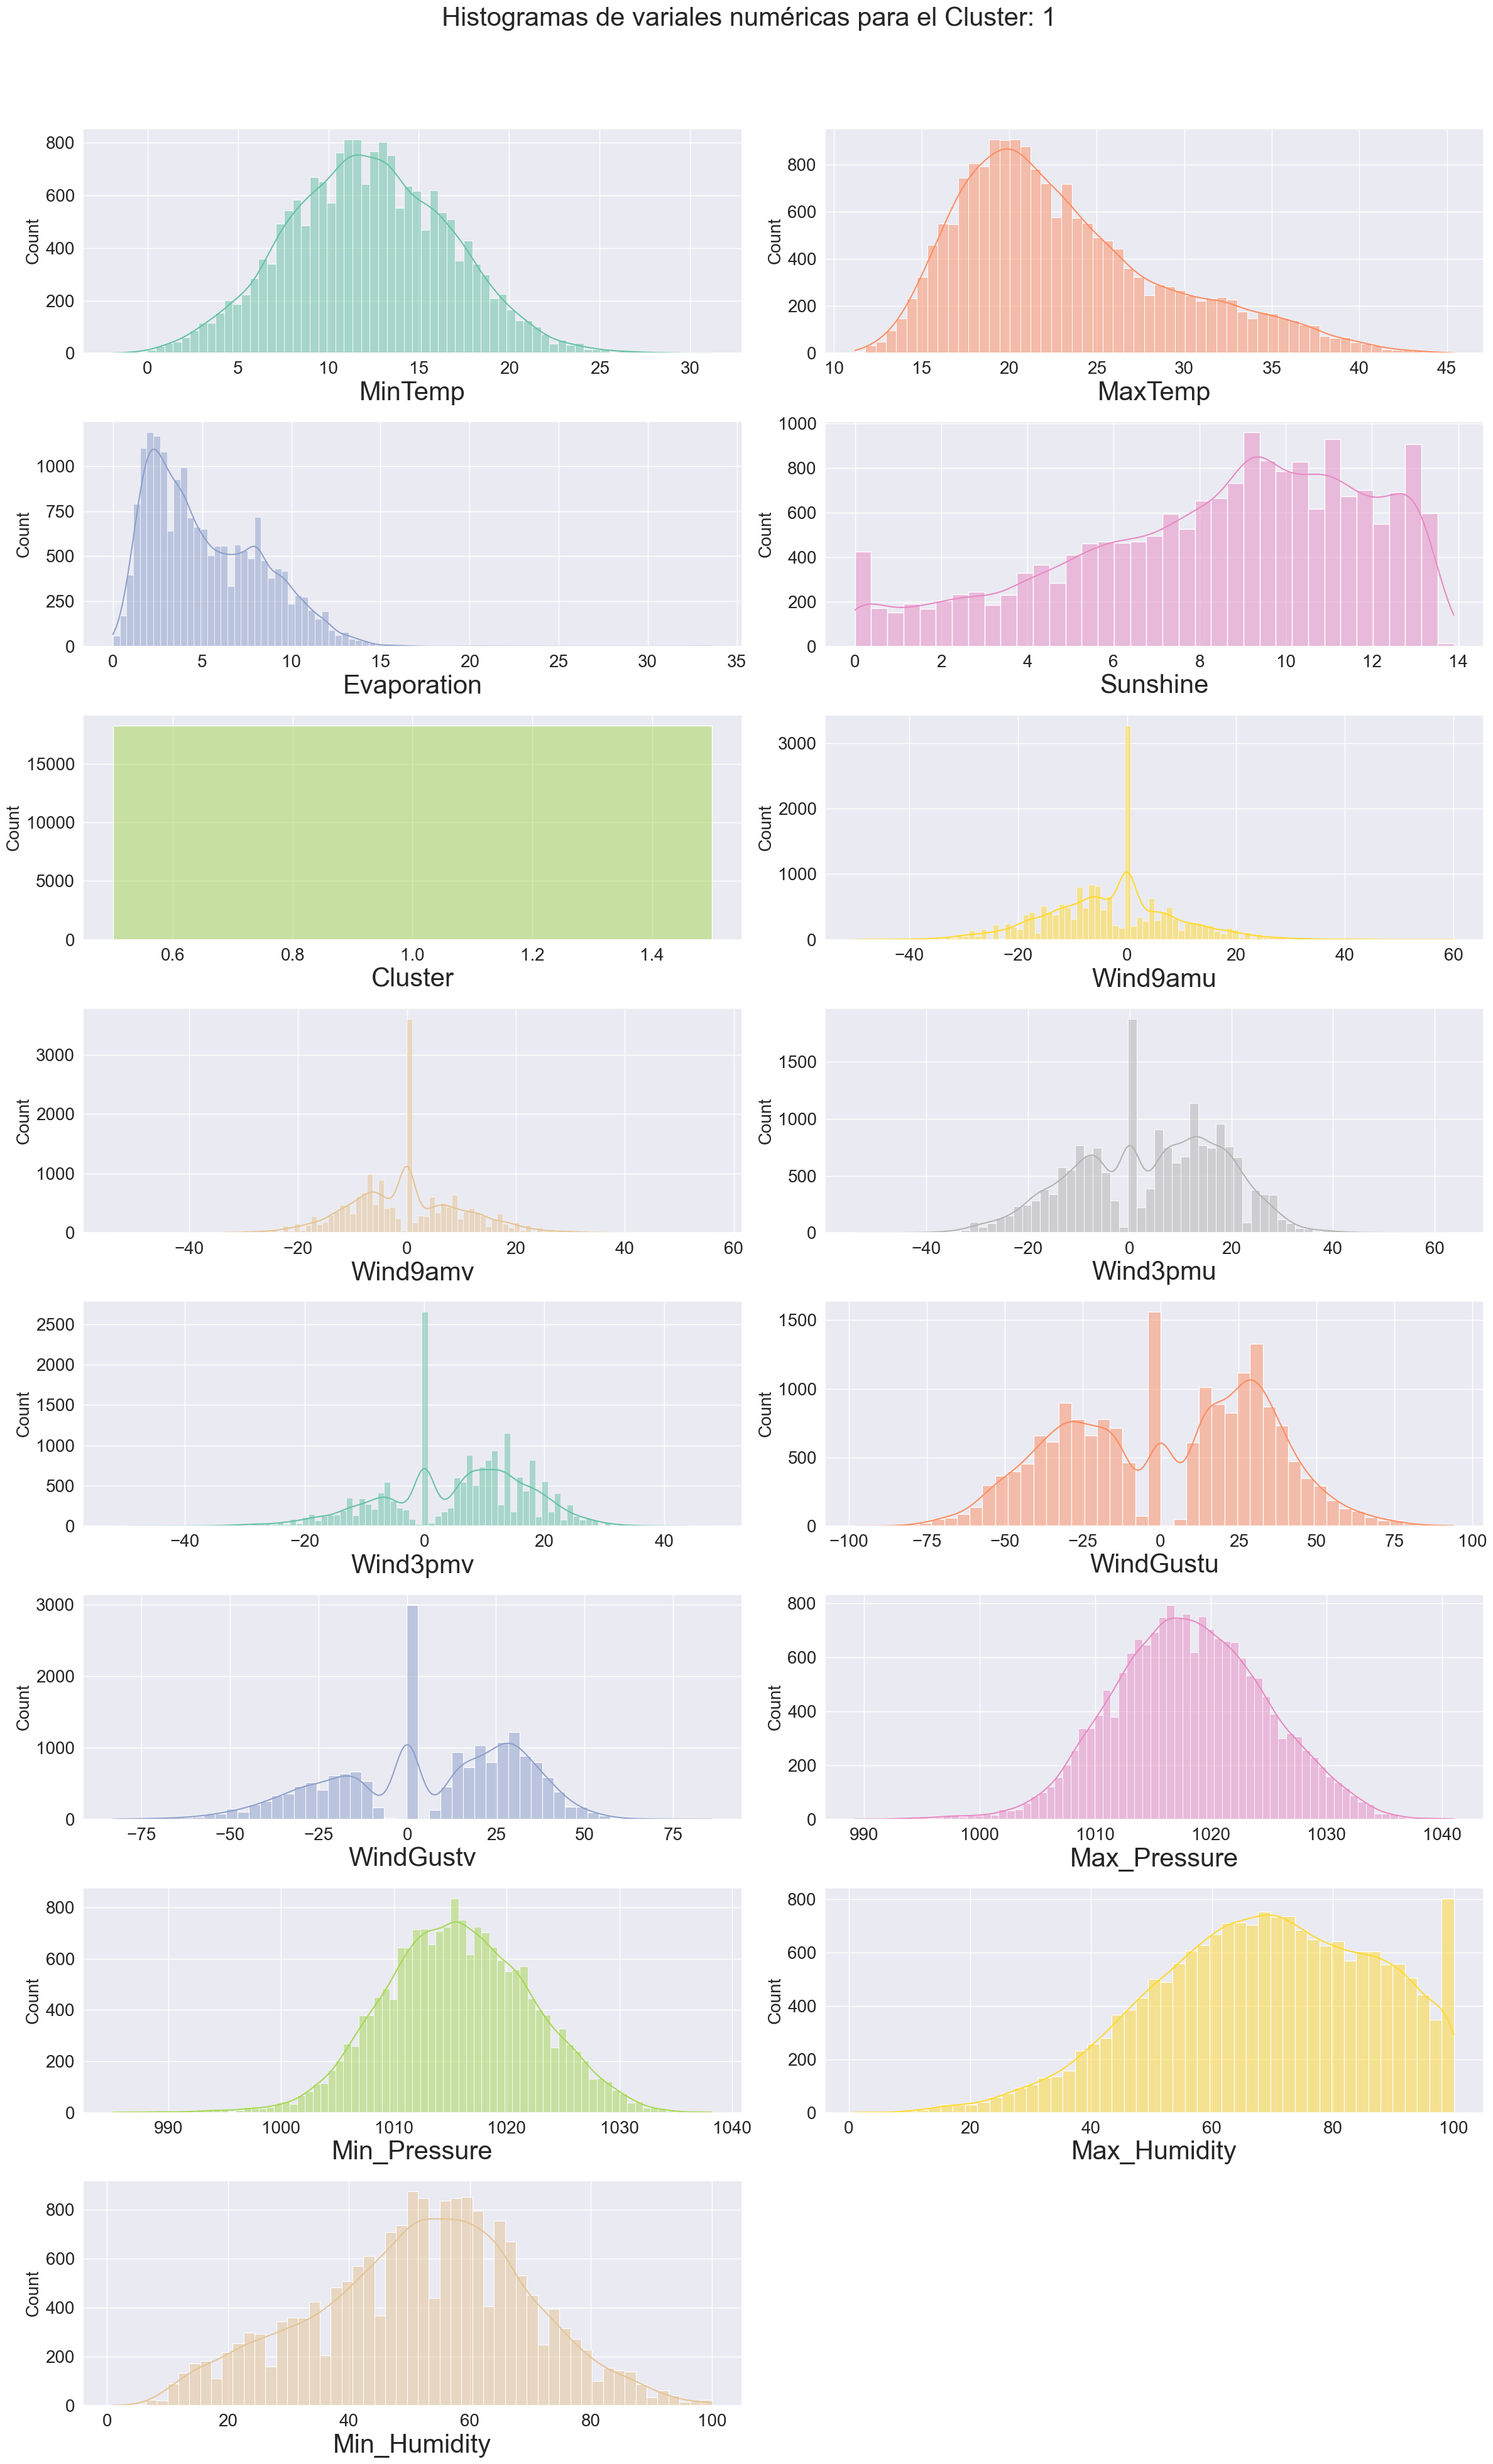

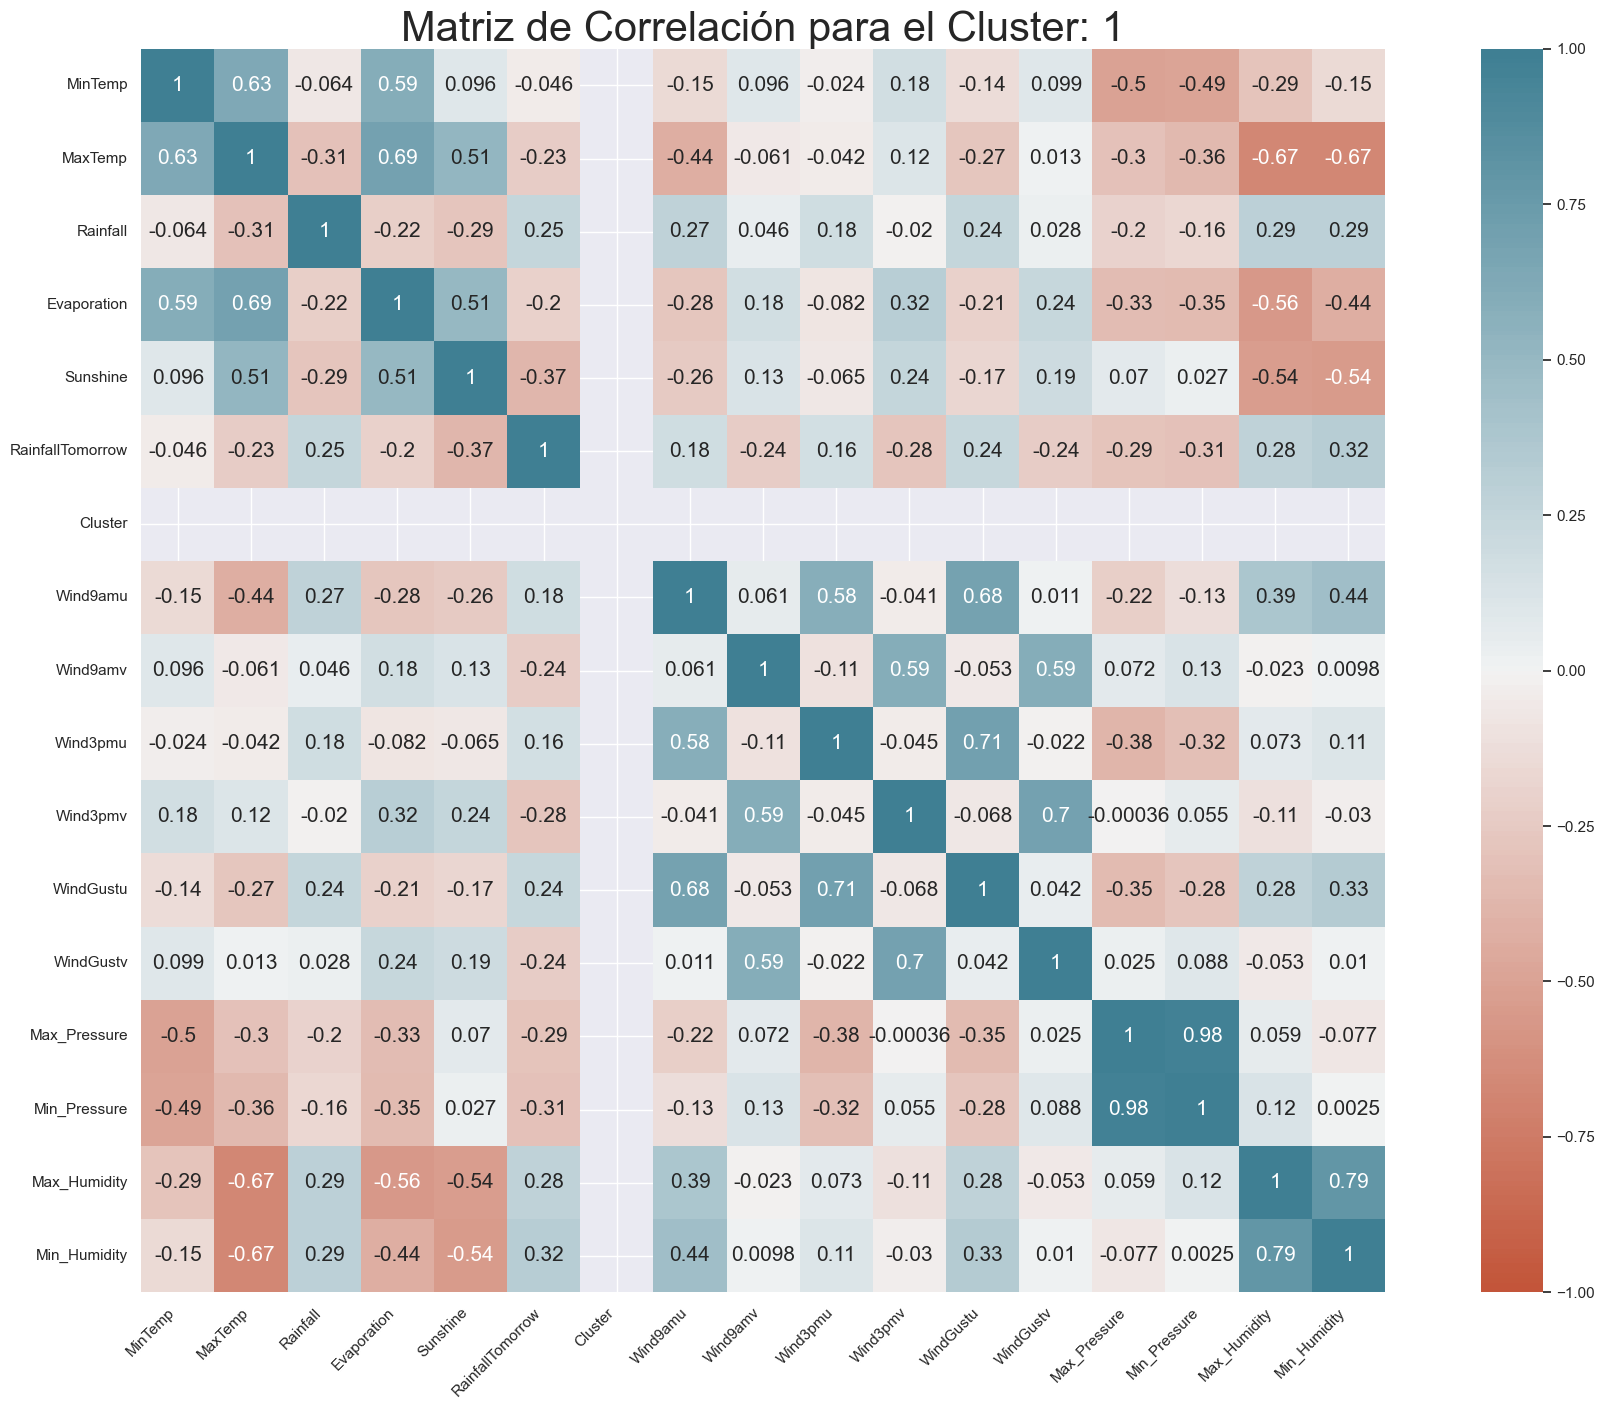

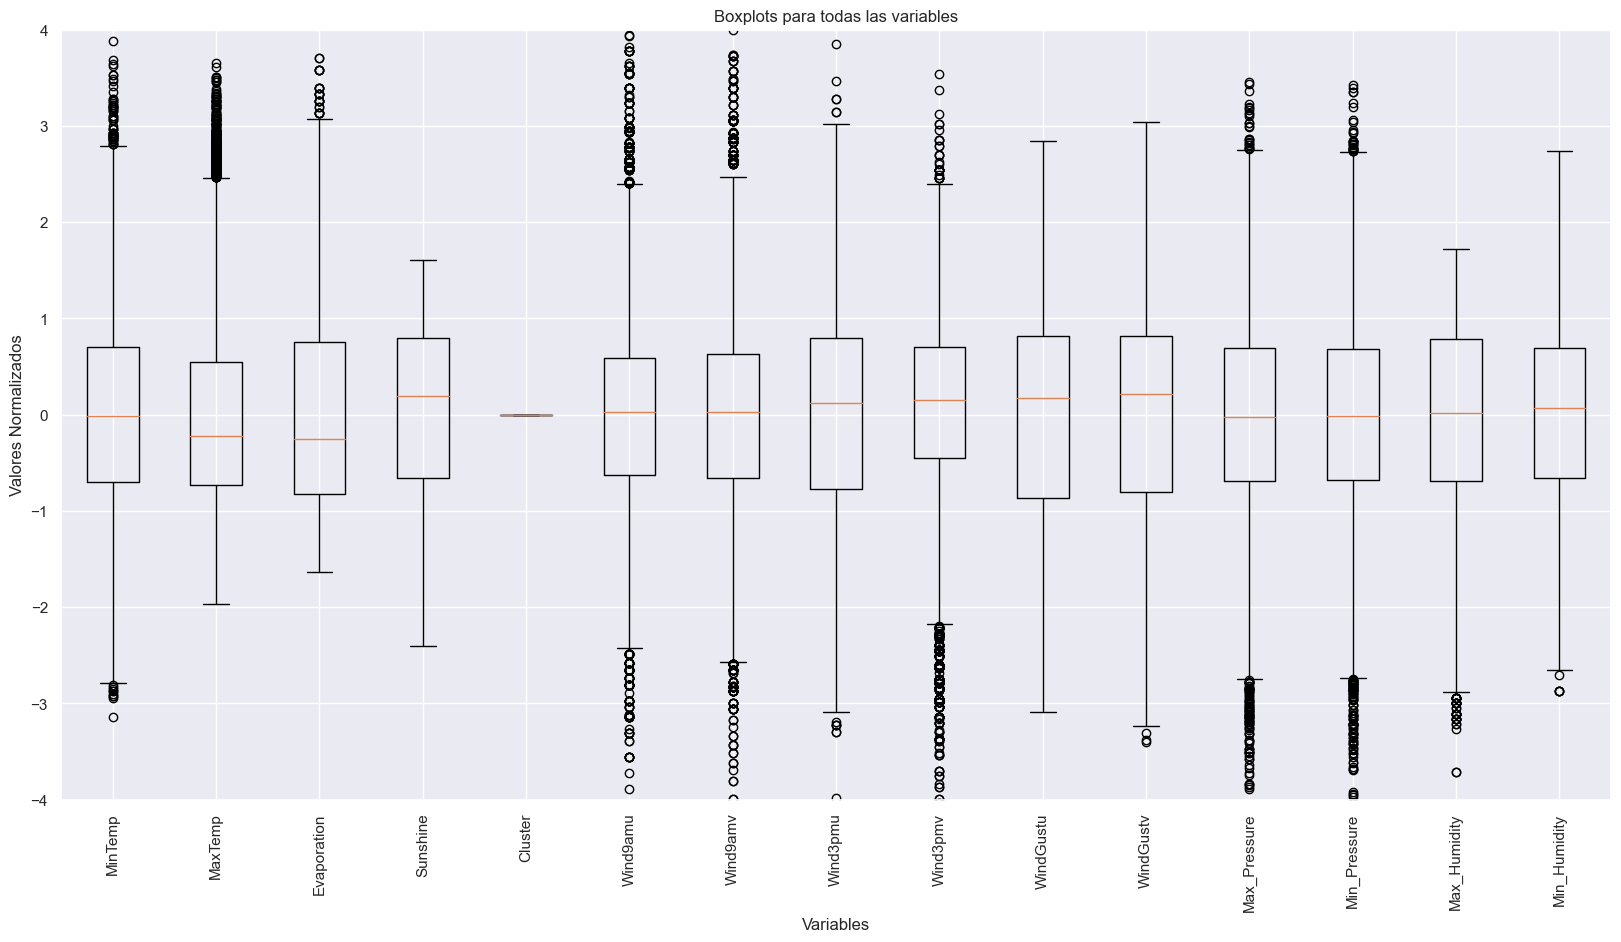

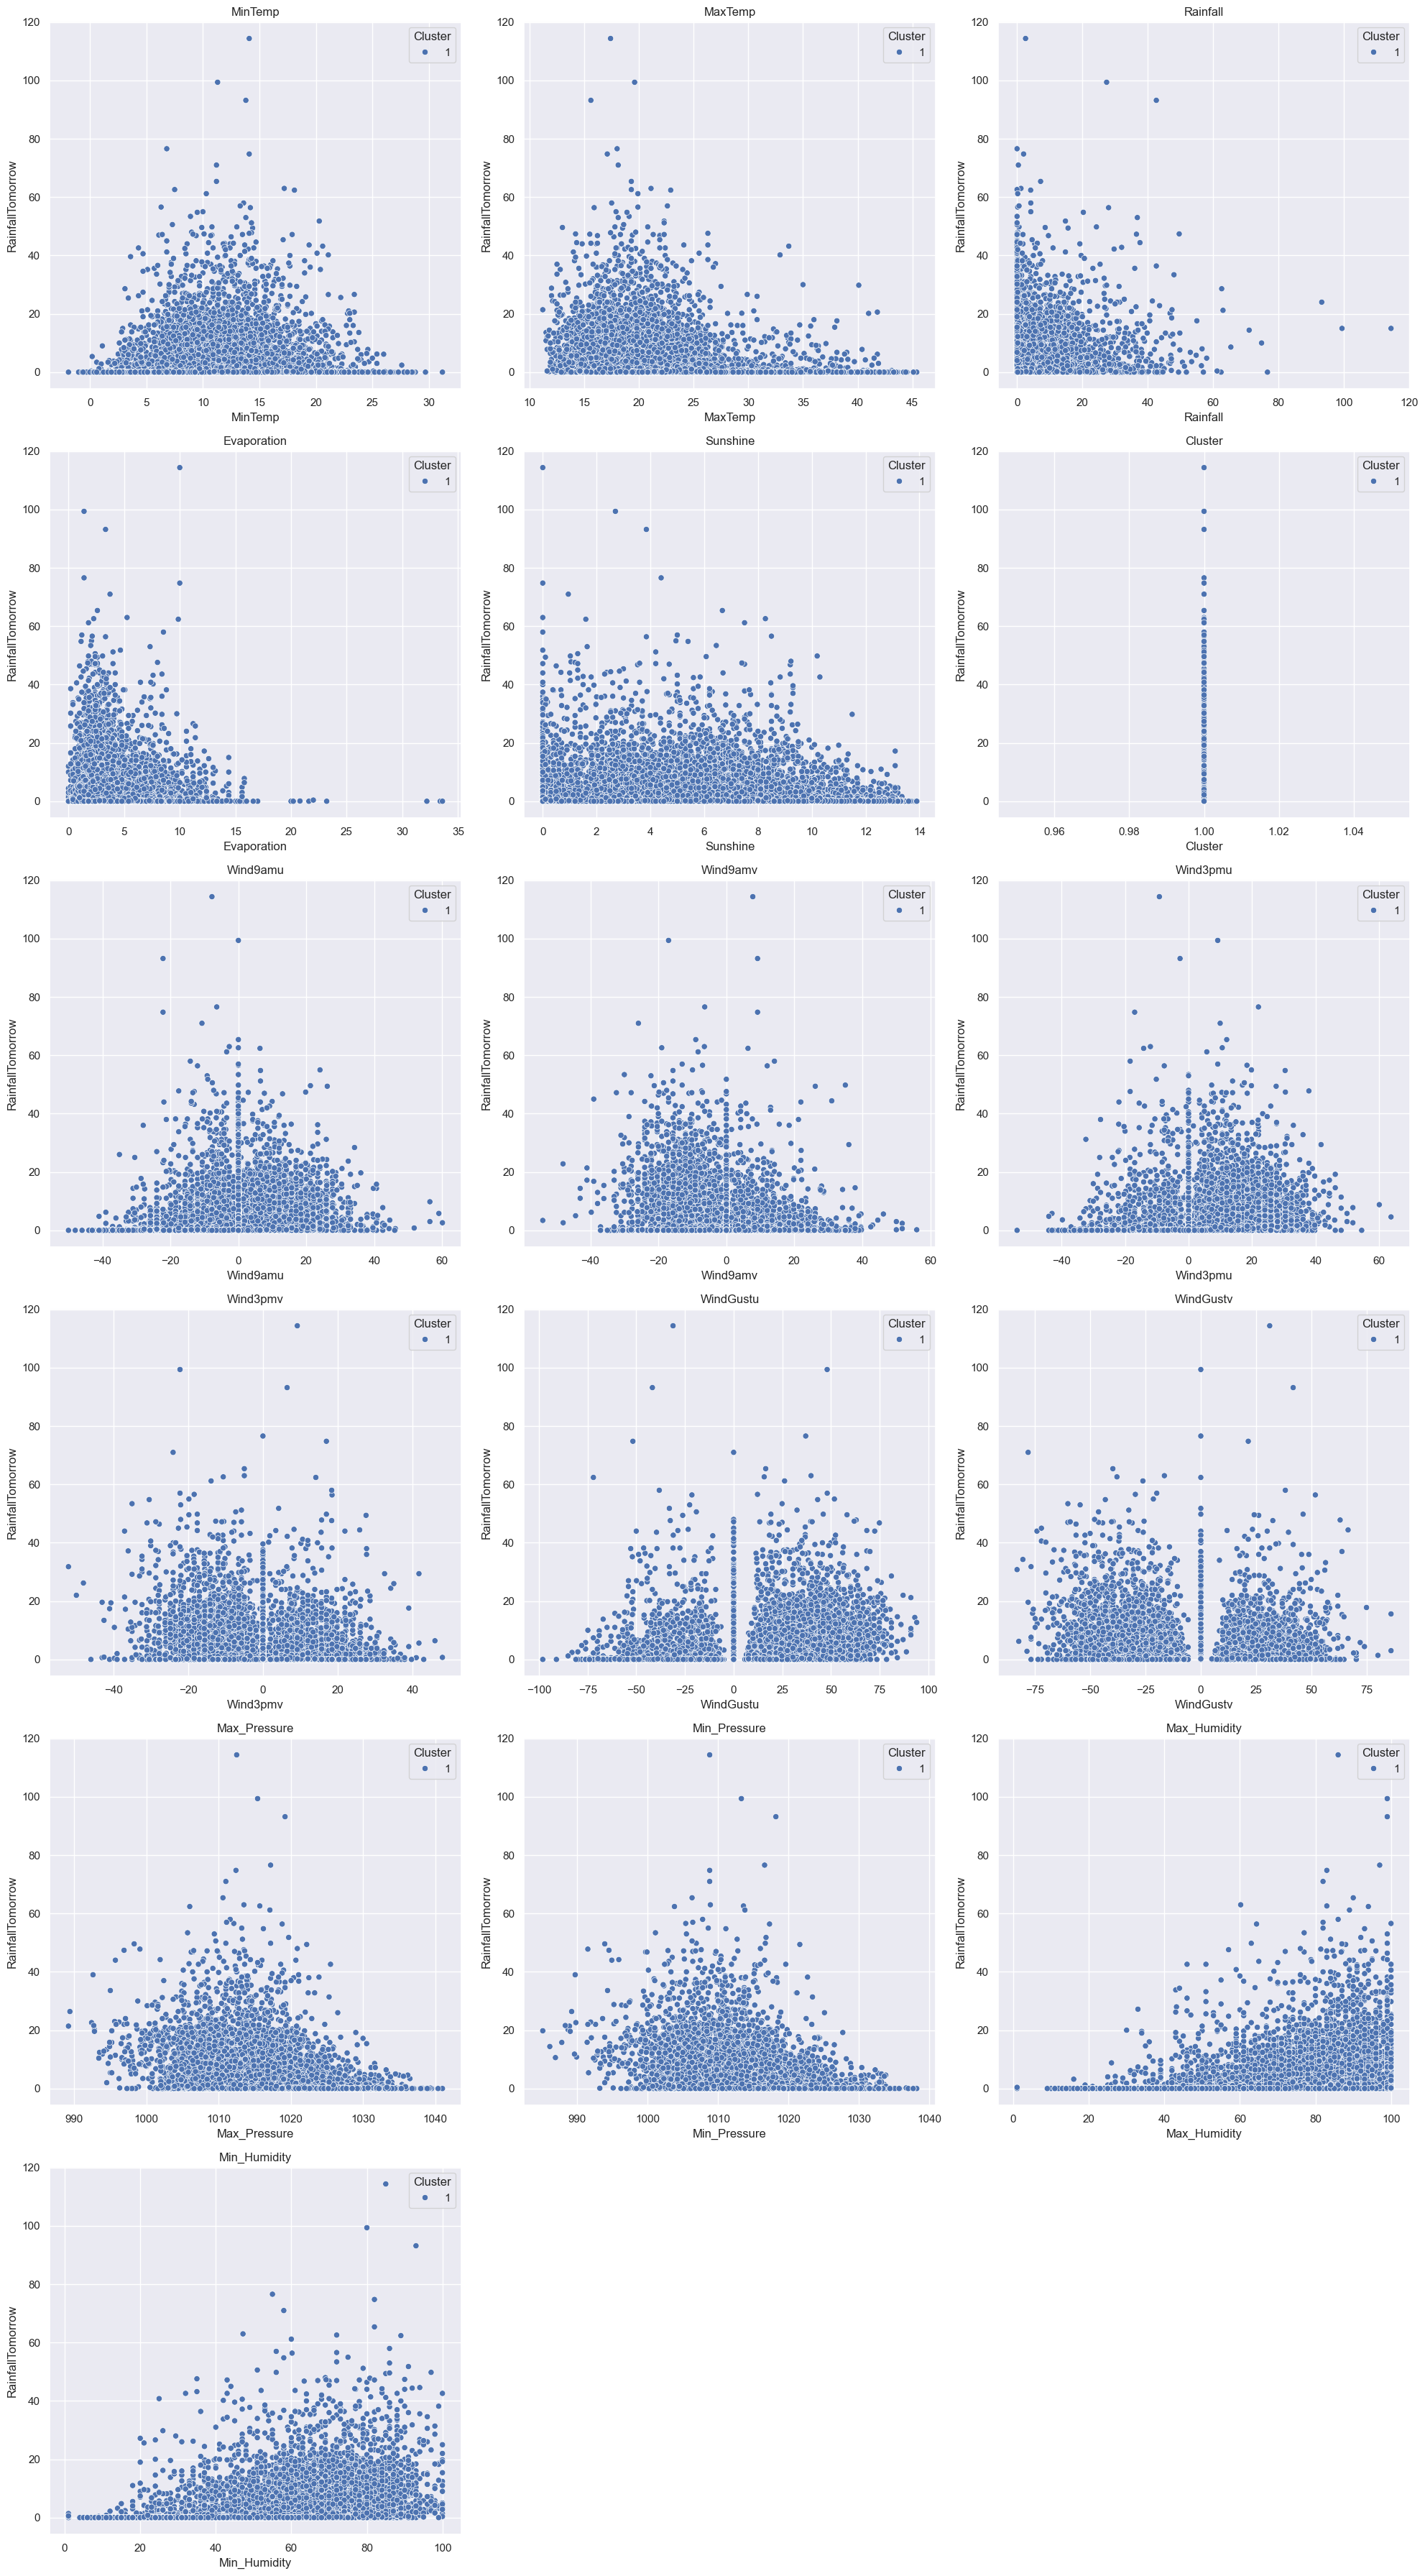

In [ ]:
graficos(cluster_dataframe(df,1))

Y también tenemos un método que nos permite ver los boxplot para un mes particular, en caso de que sea necesario.

## Eliminación de Outliers ##
Diseñamos una función que recibe el dataframe y nos elimina del mismo aquellos registros que presentan outliers en alguna de las variables númericas teniendo en cuenta un threshold que puede ser modificado para hacerlo mas o menos restrictivo. En este caso tomamos un valor de 1.5 lo que significa que eliminaremos aquellos valores que esten a mas de 1.5 veces el rango intercuartilico.

In [ ]:
def remove_outliers(df, threshold=1.5):
    cleaned_df = df.copy()
    columns = df.drop(['RainTomorrow','RainfallTomorrow','RainToday','Rainfall'],axis=1).select_dtypes(include=[float, int])
    for column in columns:
        if column in df.columns:
            # Calcular el rango intercuartílico (IQR)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Definir los límites para identificar valores atípicos
            lower_limit = Q1 - threshold * IQR
            upper_limit = Q3 + threshold * IQR

            # Eliminar valores atípicos
            cleaned_df = cleaned_df[(cleaned_df[column] >= lower_limit) & (cleaned_df[column] <= upper_limit)]

    return cleaned_df

cleaned_df = remove_outliers(df)
print("Cantidad de datos removidos:", len(df) - len(cleaned_df))

removed_percentage = ((len(df) - len(cleaned_df)) / len(df)) * 100
print("Porcentaje de datos removidos: {:.2f}%".format(removed_percentage))

Cantidad de datos removidos: 12281
Porcentaje de datos removidos: 9.30%


## Análisis de Balance ##
Para analizar el balance necesitamos determinar si la distribución de las variables target, en este caso categóricas esta uniformemente distribuida. Para eso diseñamos el siguiente método. Pretendemos que los scores estén cerca de 0.5 lo que representaría una distribución uniforme de los datos.

Balance Scores:
RainTomorrow: 0.7786573807316849


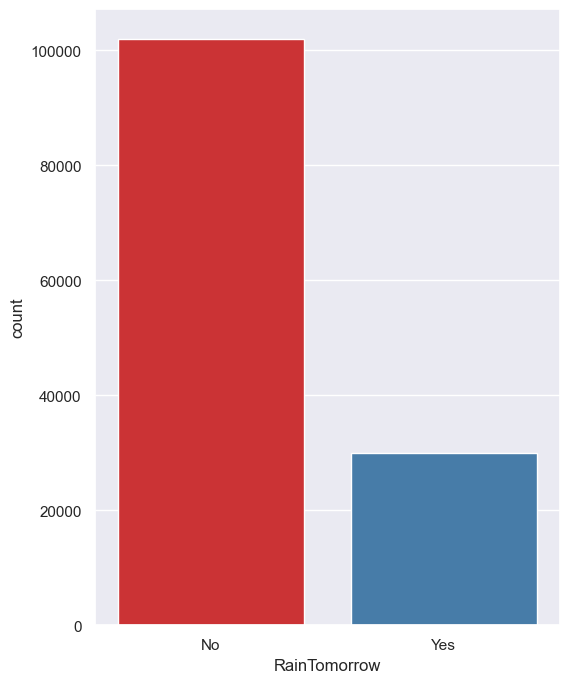

In [ ]:
def check_balance(df, target_columns):

    balance_scores = {}

    for column in target_columns:
        class_counts = df[column].value_counts()
        num_classes = len(class_counts)
        max_count = class_counts.max()
        balance_score = max_count / len(df)
        balance_scores[column] = balance_score

    return balance_scores

target_columns = ["RainTomorrow"]
balance_scores = check_balance(cleaned_df, target_columns)
print("Balance Scores:")
for column, score in balance_scores.items():
    print(f"{column}: {score}")

f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=df, palette="Set1")
plt.show()

Dado que el valor de balance ronda el 0.8, el target RainTomorrow presentan una distribución no uniforme para sus respectivos valores. Esto quiere decir que el dataset no está balanceado.

## Selección de características y Estandarización ##

Para predecir la lluvia del día siguiente, decidimos trabajar con todas las variables (originales o transformadas) del dataset.

In [ ]:
def dataframe_normalized(df,features):
    df_normalized = df.copy()
    skystate = {
        'Despejado' :               0,
        'Parcialmente Nublado' :    1,
        'Nublado' :                 2,
        'Muy Nublado' :             3
    }
    df_normalized['RainToday'] = df_normalized['RainToday'].map({'No': 0, 'Yes': 1})
    df_normalized['RainTomorrow'] = df_normalized['RainTomorrow'].map({'No': 0, 'Yes': 1})
    df_normalized['Date']=df_normalized['Date'].dt.dayofyear
    df_normalized['Estado_Cielo'] = df_normalized['Estado_Cielo'].map(skystate)
    scaler = StandardScaler()
    df_normalized[features] = scaler.fit_transform(df_normalized[features])
    return df_normalized

def obtención_de_datos(df,features,target,date=1):
    df_copy=df.copy()
    x=df_copy[features].values.reshape(-1,len(features))
    y=df_copy[target].values.reshape(-1,1)
    return x,y

In [ ]:
columns =   [
                'MinTemp', 
                'MaxTemp', 
                'Evaporation',
                'Sunshine',
                'Wind9amu', 
                'Wind9amv', 
                'Wind3pmu', 
                'Wind3pmv', 
                'WindGustu',
                'WindGustv', 
                'Max_Pressure',
                'Min_Pressure',
                'Max_Humidity',
                'Min_Humidity',
                'Estado_Cielo',
                'Cluster',
                'Date'
            ]

x,y=obtención_de_datos(dataframe_normalized(cleaned_df,columns),columns,'RainfallTomorrow')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Modelos y Rendimiento ##

In [ ]:
def r2_score(y_true,y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def r2_ajusted(y_true,y_pred,n,p):
    r2 = r2_score(y_true,y_pred)
    r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return r2_ajustado

def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def mean_absolute_error(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

### Regresión Global ###

In [ ]:
# Crear un modelo de regresión lineal
lr = LinearRegression(fit_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rg = lr.predict(X_test)

# Calcular las métricas de evaluación
r2 = r2_score(y_test, y_pred_rg)
mse = mean_squared_error(y_test, y_pred_rg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rg)

# Imprimir las métricas de evaluación
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 ajustado: {r2_ajusted(y_test,y_pred_rg,len(y_test),len(X_test[0])):.4f}")

R^2: 0.1519
MSE: 52.9142
RMSE: 7.2742
MAE: 3.3403
R^2 ajustado: 0.1513


### Regresión por Cluster ###

In [ ]:
# Inicializar un DataFrame vacío para almacenar los resultados
results_list = []

for i in range(1, 13):
    cl = cluster_dataframe(cleaned_df, i)
    if len(cl) < 100:
        continue
    x_cl, y_cl = obtención_de_datos(dataframe_normalized(cl, columns), columns, 'RainfallTomorrow')
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(x_cl, y_cl, test_size=0.2, random_state=1)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X_cl_train, y_cl_train)
    y_cl_pred = lr.predict(X_cl_test)

    r2 = r2_score(y_cl_test, y_cl_pred)
    mse = mean_squared_error(y_cl_test, y_cl_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_cl_test, y_cl_pred)

    # Agregar los resultados de esta iteración a la lista
    results_list.append(pd.DataFrame({'Cluster': [i], 'R^2': [r2], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]}))

# Combinar todos los DataFrames en un único DataFrame
cluster_results = pd.concat(results_list, ignore_index=True)

# Mostrar el resultado
cluster_results

Cluster       R^2         MSE       RMSE       MAE
0         1  0.279587   25.667827   5.066343  2.649761
1         2  0.166878   73.029996   8.545759  3.877563
2         3  0.209874   18.634100   4.316723  1.790407
3         4  0.231335   34.622717   5.884107  2.780382
4         5  0.202140   53.435407   7.309953  3.728478
5         6  0.193521  157.925699  12.566849  6.689831
6         7  0.188639  103.899235  10.193097  5.274664
7         8  0.196069   18.480586   4.298905  2.119309
8         9  0.171097  105.211003  10.257241  4.899370
9        10  0.238340   16.112496   4.014037  1.827109
10       12  0.139699   16.968077   4.119233  2.214145

### Regresión por Ciudad ###

In [ ]:
ciudades = cleaned_df['Location'].unique()
city_results = []

for i in ciudades:
    x_c, y_c = obtención_de_datos(dataframe_normalized(city_dataframe(cleaned_df, i), columns), columns, 'RainfallTomorrow')
    X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(x_c, y_c, test_size=0.2, random_state=1)
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X_c_train, y_c_train)
    y_c_pred = lr.predict(X_c_test)

    r2 = r2_score(y_c_test, y_c_pred)
    mse = mean_squared_error(y_c_test, y_c_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_c_test, y_c_pred)

    city_results.append(pd.DataFrame({'Cluster': [i], 'Cant_datos': [len(city_dataframe(cleaned_df, i))], 'R^2': [r2], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]}))

# Combinar todos los DataFrames en un único DataFrame
city_results_df = pd.concat(city_results, ignore_index=True)

# Mostrar el resultado
city_results_df

Cluster  Cant_datos       R^2         MSE       RMSE       MAE
0             Albury        2515  0.283712   18.722459   4.326946  2.785150
1      BadgerysCreek        2886  0.217793   43.871680   6.623570  3.101884
2              Cobar        2296  0.228740   18.477007   4.298489  1.914553
3       CoffsHarbour        2858  0.230573  151.059785  12.290638  6.770998
4              Moree        2654  0.153064   41.759135   6.462131  2.916306
5          Newcastle        2893  0.118231  141.164398  11.881262  4.595259
6          NorahHead        2685  0.178158   72.160827   8.494753  4.388196
7      NorfolkIsland        2170  0.202140   53.435407   7.309953  3.728478
8            Penrith        2925  0.209348   37.718425   6.141533  2.966904
9           Richmond        2832  0.190180   54.465441   7.380071  3.313995
10            Sydney        2877  0.235993   76.979953   8.773822  4.303227
11     SydneyAirport        2593  0.169289   56.619225   7.524575  3.646719
12        WaggaWagga        2428  0.211606   14.250622   3.775000  2.253992
13       Williamtown        2567  0.152546  132.637635  11.516841  4.665708
14        Wollongong        2691  0.163245   81.643436   9.035676  4.362636
15          Canberra        2803  0.216419   30.127972   5.488895  2.509891
16       Tuggeranong        2503  0.246196   44.746818   6.689306  3.386074
17       MountGinini        2099  0.239198   44.476889   6.669100  3.818066
18          Ballarat        2556  0.178861   27.649503   5.258279  2.159182
19           Bendigo        2944  0.252809   25.903372   5.089536  2.438213
20              Sale        2605  0.175441   17.158595   4.142293  2.116402
21  MelbourneAirport        2324  0.224143   12.276916   3.503843  1.771593
22         Melbourne        2535  0.075643   14.450139   3.801334  2.052059
23           Mildura        2675  0.115704   25.048047   5.004802  1.729967
24              Nhil        1311  0.150644    9.967094   3.157071  1.468354
25          Portland        2606  0.196026   32.599972   5.709639  2.755319
26          Watsonia        2880  0.192117   20.877124   4.569149  2.251327
27          Dartmoor        2757  0.281424   20.281151   4.503460  2.212242
28          Brisbane        3161  0.224370  142.992580  11.957950  4.955454
29            Cairns        2572  0.246659  339.472809  18.424788  8.200068
30         GoldCoast        2564  0.170472  107.993518  10.391993  4.741801
31        Townsville        2504  0.179157  161.088093  12.692048  5.519755
32          Adelaide        2324  0.283634   10.465547   3.235050  1.935243
33      MountGambier        2627  0.181199   19.296461   4.392774  2.287874
34         Nuriootpa        2373  0.232712   22.587025   4.752581  2.007318
35           Woomera        1787  0.151460    4.829616   2.197639  1.166825
36            Albany        2781  0.310625   20.332815   4.509192  2.600172
37       Witchcliffe        2939  0.338778   33.058891   5.749686  3.341212
38        PearceRAAF        2698  0.351062   12.640175   3.555302  2.282851
39      PerthAirport        2623  0.339047   23.853378   4.883992  2.672993
40             Perth        3135  0.310733   28.025592   5.293920  2.625935
41           Walpole        2932  0.336052   23.824917   4.881077  2.890661
42            Hobart        1744  0.187150    9.776325   3.126712  1.694854
43        Launceston        1706  0.161772   26.590221   5.156571  2.503264
44      AliceSprings        1551  0.216293   22.460574   4.739259  1.868247
45            Darwin        3003  0.244449  198.485803  14.088499  5.870739
46         Katherine        1534  0.150026  132.903325  11.528370  4.495026
47             Uluru         725  0.072564   22.838757   4.778991  1.817435

De los resultados obtenemos la conclusión de que el modelo se comporta mejor cuando no consideramos todas las ciudades en un mismo conjunto. Podemos usar un modelo por cluster o uno por ciudad y salvo raras excepciones, dichos modelos presentarán un mejor rendimiento que el modelo global. Estas diferencias podrían deberse a que las ciudades presentan distintos climas y por lo tanto distintos patrones de comportamiento.	

### Gradient Descent ###

In [ ]:
#Función Gradient Descent

def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, plot=True):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    p = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((p, 1)), X_test))
    
    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W) 
        error_test = y_test - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    if plot==True:
        print(f"Error de entrenamiento final: {train_errors[-1]:.4f}")
        print(f"Error de prueba final: {test_errors[-1]:.4f}")
        print(f"Pesos finales: {W.T}")

        # Graficar errores de entrenamiento y prueba
        # Definir una figura
        plt.figure(figsize=(12, 6))
        # Plotear errores de entrenamiento
        plt.plot(train_errors, label='Error de entrenamiento')
        # Plotear errores de prueba
        plt.plot(test_errors, label='Error de test')
        # Poner labels en los ejes
        plt.xlabel('Época')
        plt.ylabel('Error cuadrático medio')
        # Activar la leyenda
        plt.legend()
        # Poner titulo
        plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
        # Terminar y mostrar gráfico
        plt.show()

    return W

In [ ]:
W = gradient_descent(X_train, y_train, X_test, y_test, lr=0.00001, epochs=100, plot=False)

# Calcular predicciones en el conjunto de prueba
y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), W)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R^2: -0.6881
MSE: 105.3201
RMSE: 10.2626
MAE: 5.5822


Para ambos modelos, las métricas de evaluación indican que el modelo actual tiene un rendimiento insatisfactorio. El coeficiente de determinación (R^2) es bajo, lo que significa que el modelo no logra explicar con mucha precisión los datos. Además, el Error Cuadrático Medio (MSE) y la Raíz del Error Cuadrático Medio (RMSE) son relativamente altos, lo que sugiere que las predicciones del modelo tienen errores significativos en comparación con los valores reales. El Error Absoluto Medio (MAE) muestra un error absoluto promedio de alrededor de 4 unidades en la misma escala que los datos. En general, estos resultados indican que el modelo necesita mejoras o que la relación entre las características y la variable de respuesta no se está modelando de manera adecuada

In [ ]:
gd_city_results = []

for i in ciudades:
    W = gradient_descent(X_train, y_train, X_test, y_test, lr=0.00001, epochs=100, plot=False)
    
    y_pred = np.matmul(np.hstack((np.ones((X_test.shape[0], 1)), X_test)), W)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    gd_city_results.append(pd.DataFrame({'Cluster': [i], 'Cant_datos': [len(city_dataframe(cleaned_df, i))], 'R^2': [r2], 'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae]}))

# Combinar todos los DataFrames en un único DataFrame
gd_city_results_df = pd.concat(gd_city_results, ignore_index=True)

# Mostrar el resultado
city_results_df

Cluster  Cant_datos       R^2         MSE       RMSE       MAE
0             Albury        2515  0.283712   18.722459   4.326946  2.785150
1      BadgerysCreek        2886  0.217793   43.871680   6.623570  3.101884
2              Cobar        2296  0.228740   18.477007   4.298489  1.914553
3       CoffsHarbour        2858  0.230573  151.059785  12.290638  6.770998
4              Moree        2654  0.153064   41.759135   6.462131  2.916306
5          Newcastle        2893  0.118231  141.164398  11.881262  4.595259
6          NorahHead        2685  0.178158   72.160827   8.494753  4.388196
7      NorfolkIsland        2170  0.202140   53.435407   7.309953  3.728478
8            Penrith        2925  0.209348   37.718425   6.141533  2.966904
9           Richmond        2832  0.190180   54.465441   7.380071  3.313995
10            Sydney        2877  0.235993   76.979953   8.773822  4.303227
11     SydneyAirport        2593  0.169289   56.619225   7.524575  3.646719
12        WaggaWagga        2428  0.211606   14.250622   3.775000  2.253992
13       Williamtown        2567  0.152546  132.637635  11.516841  4.665708
14        Wollongong        2691  0.163245   81.643436   9.035676  4.362636
15          Canberra        2803  0.216419   30.127972   5.488895  2.509891
16       Tuggeranong        2503  0.246196   44.746818   6.689306  3.386074
17       MountGinini        2099  0.239198   44.476889   6.669100  3.818066
18          Ballarat        2556  0.178861   27.649503   5.258279  2.159182
19           Bendigo        2944  0.252809   25.903372   5.089536  2.438213
20              Sale        2605  0.175441   17.158595   4.142293  2.116402
21  MelbourneAirport        2324  0.224143   12.276916   3.503843  1.771593
22         Melbourne        2535  0.075643   14.450139   3.801334  2.052059
23           Mildura        2675  0.115704   25.048047   5.004802  1.729967
24              Nhil        1311  0.150644    9.967094   3.157071  1.468354
25          Portland        2606  0.196026   32.599972   5.709639  2.755319
26          Watsonia        2880  0.192117   20.877124   4.569149  2.251327
27          Dartmoor        2757  0.281424   20.281151   4.503460  2.212242
28          Brisbane        3161  0.224370  142.992580  11.957950  4.955454
29            Cairns        2572  0.246659  339.472809  18.424788  8.200068
30         GoldCoast        2564  0.170472  107.993518  10.391993  4.741801
31        Townsville        2504  0.179157  161.088093  12.692048  5.519755
32          Adelaide        2324  0.283634   10.465547   3.235050  1.935243
33      MountGambier        2627  0.181199   19.296461   4.392774  2.287874
34         Nuriootpa        2373  0.232712   22.587025   4.752581  2.007318
35           Woomera        1787  0.151460    4.829616   2.197639  1.166825
36            Albany        2781  0.310625   20.332815   4.509192  2.600172
37       Witchcliffe        2939  0.338778   33.058891   5.749686  3.341212
38        PearceRAAF        2698  0.351062   12.640175   3.555302  2.282851
39      PerthAirport        2623  0.339047   23.853378   4.883992  2.672993
40             Perth        3135  0.310733   28.025592   5.293920  2.625935
41           Walpole        2932  0.336052   23.824917   4.881077  2.890661
42            Hobart        1744  0.187150    9.776325   3.126712  1.694854
43        Launceston        1706  0.161772   26.590221   5.156571  2.503264
44      AliceSprings        1551  0.216293   22.460574   4.739259  1.868247
45            Darwin        3003  0.244449  198.485803  14.088499  5.870739
46         Katherine        1534  0.150026  132.903325  11.528370  4.495026
47             Uluru         725  0.072564   22.838757   4.778991  1.817435

## Regularización ##

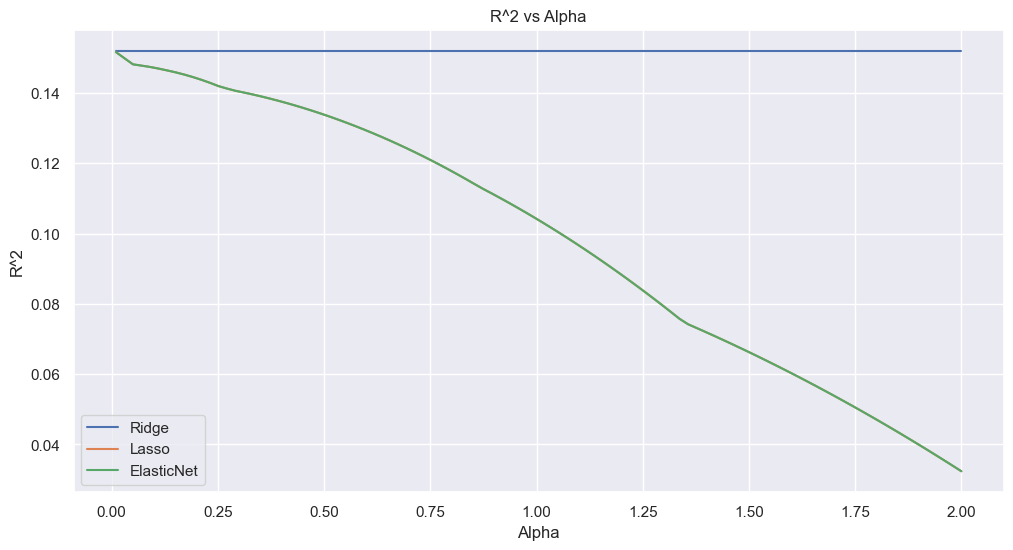

In [ ]:
alphas = np.linspace(0.01, 2, 100)
score_ridge = []
score_lasso = []
score_elasticnet = []
for alpha in alphas:
    #print("Alpha:", alpha)
    # Crear modelos de regresión lineal, Lasso y Ridge
    lr = LinearRegression()
    lasso = Lasso(alpha)
    ridge = Ridge(alpha)
    elasticnet = ElasticNet(alpha, l1_ratio=1)

    # Ajustar modelos a los datos
    lr.fit(x, y)
    lasso.fit(x, y)
    ridge.fit(x, y)
    elasticnet.fit(x,y)

    score_ridge.append(ridge.score(x,y))
    score_lasso.append(lasso.score(x,y))
    score_elasticnet.append(elasticnet.score(x,y))

plt.figure(figsize=(12, 6))
plt.plot(alphas, score_ridge, label='Ridge')
plt.plot(alphas, score_lasso, label='Lasso')
plt.plot(alphas, score_elasticnet, label='ElasticNet')
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.legend()
plt.title('R^2 vs Alpha')
plt.show()

Text(0.5, 1.0, 'R^2 vs L1')

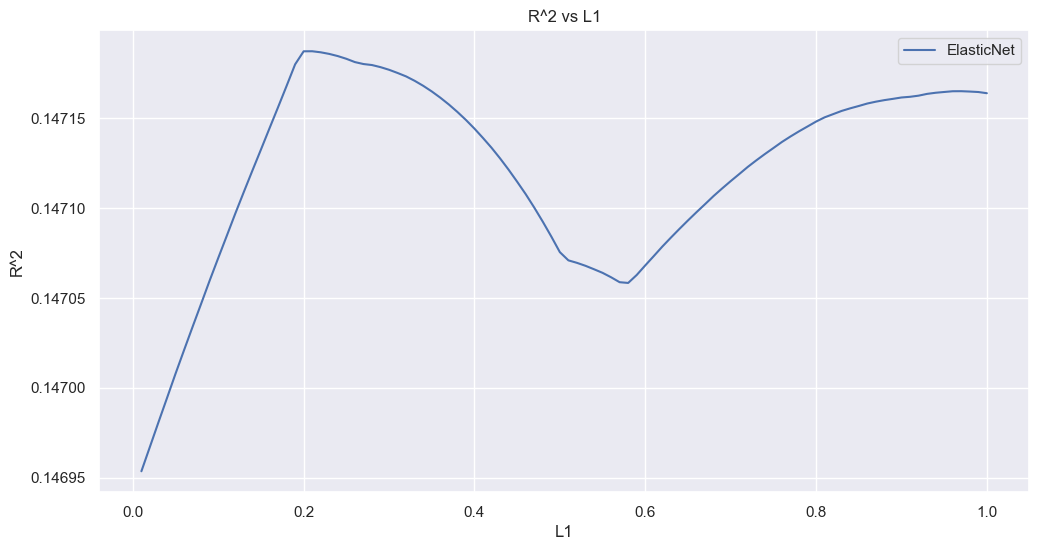

In [ ]:
l1=np.linspace(0.01, 1, 100)
score_elasticnet = []
for l in l1:
    # Crear modelos de regresión lineal, Lasso y Ridge
    lr = LinearRegression()
    elasticnet = ElasticNet(alpha=0.1, l1_ratio=l)
    score_elasticnet.append(elasticnet.fit(x,y).score(x,y))

plt.figure(figsize=(12, 6))
plt.plot(l1, score_elasticnet, label='ElasticNet')
plt.xlabel('L1')
plt.ylabel('R^2')
plt.legend()
plt.title('R^2 vs L1')

La mala performance puede deberse, a distintos factores entre los que se encuentran:
- La transformación de los datos no fue la adecuada.
- Los outliers en los datos son mas de los que se esperaba y no se eliminaron correctamente, o inversamente, al eliminar ciertos outliers perdimos información importante.
- La cantidad de datos no es suficiente para entrenar un modelo de regresión lineal.
- La relación entre las variables y la variable target no es lineal.
- La cantidad de variables es muy grande y no todas son relevantes para el modelo.
- La cantidad de variables es muy grande y existe multicolinealidad entre ellas.

Nuestra hipótesis es que un modelo de regresión lineal no es el adecuado para este problema, ya que la relación entre las variables y la variable target no es lineal, esto pudo notarse también al hacer la visualización de los datos, los gráficos presentados podrían haber estado prediciendo este resultado. Por lo tanto, se debería utilizar un modelo de regresión no lineal, como por ejemplo un modelo de regresión polinomial. Se intentara mejorar los resultados en el futuro. 

## Regresión Logística ##

Pretendemos predecir ahora la variable "RainTomorrow" que es una variable categórica. Para esto utilizaremos un modelo de regresión logística. Mostraremos los boxplots según variables para encontrar cuáles de ellas pueden darnos información mas significativa.

In [ ]:
columns =       [
                    'MinTemp', 
                    'MaxTemp', 
                    'Evaporation',
                    'Sunshine',
                    'Wind9amu', 
                    'Wind9amv', 
                    'Wind3pmu', 
                    'Wind3pmv', 
                    'WindGustu',
                    'WindGustv', 
                    'Max_Pressure',
                    'Min_Pressure',
                    'Max_Humidity',
                    'Min_Humidity'
                ]

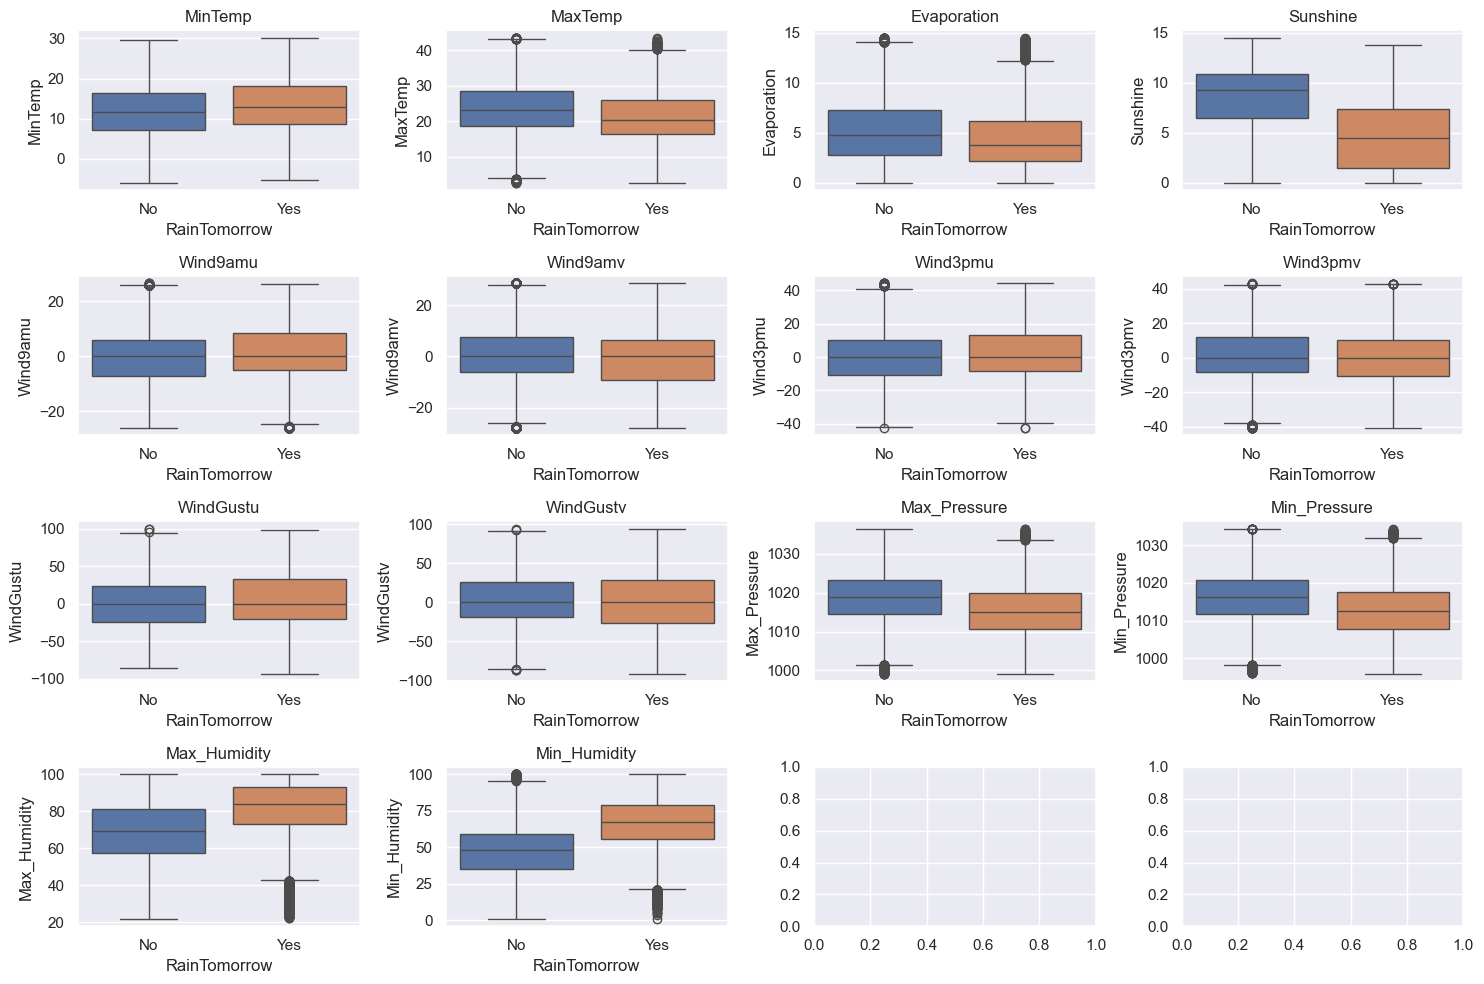

In [ ]:
# Crea una figura y subplots
num_rows = 4
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Itera sobre las columnas y crea un gráfico en cada subplot
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    sns.boxplot(data=cleaned_df, x='RainTomorrow', y=column, hue='RainTomorrow', ax=ax)
    ax.set_title(column)

# Ajusta el diseño y muestra la figura
plt.tight_layout()
plt.show()

Vemos que casi todas las variables mantienen una distribución similar para ambos valores de la variable target, excepto para las variables "Sunshine" que presenta una distribución muy distinta para ambos valores de la variable target y en menor medida pero que aún se podría considerar importante, la vairable "Min_Humidity". Esto nos indica que ambas variables podrían ser muy significativas para nuestro modelo.

In [ ]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Min_Humidity'],'RainTomorrow',0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calcular las métricas de evaluación
print('Puntaje de precisión del modelo: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Resultados con regresión logística

              precision    recall  f1-score   support

          No       0.91      0.74      0.82     18734
         Yes       0.45      0.74      0.56      5217

    accuracy                           0.74     23951
   macro avg       0.68      0.74      0.69     23951
weighted avg       0.81      0.74      0.76     23951

[[13936  4798]
 [ 1369  3848]]
Puntaje de precisión del modelo: 0.7425


### Resultados de la Clasificación

**Matriz de Confusión:**

- **Verdaderos Positivos (True Positives, TP):** 3577. Son los casos en los que el modelo predijo "Sí" y la respuesta real fue "Sí".

- **Falsos Positivos (False Positives, FP):** 4648. Son los casos en los que el modelo predijo "Sí" pero la respuesta real fue "No".

- **Verdaderos Negativos (True Negatives, TN):** 13990. Son los casos en los que el modelo predijo "No" y la respuesta real fue "No".

- **Falsos Negativos (False Negatives, FN):** 1564. Son los casos en los que el modelo predijo "No" pero la respuesta real fue "Sí".

**Métricas de Evaluación:**

- **Precisión (Precision):** Es la proporción de verdaderos positivos respecto a todos los positivos predichos. En este caso, la precisión para la etiqueta "No" es 0.90 lo que significa que el 90% de las predicciones positivas para "No" son correctas, mientras que para la etiqueta "Yes" es 0.43, lo que significa que el 43% de las predicciones positivas para "Yes" son correctas.

- **Recall:** Es la proporción de verdaderos positivos respecto a todos los verdaderos positivos y falsos negativos. En este caso, el recall es 0.75 para la etiqueta "No" y 0.70 para la etiqueta "Yes" lo que significa que el modelo captura el 75% de todos los casos reales de "No" y el 70% de todos los casos reales de "Yes".

- **F1-score:** Es la media armónica de precisión y recall. En este caso, el F1-score para la etiqueta "Yes" es 0.54 y 0.82 para la etiqueta "No".

- **Exactitud (Accuracy):** Es la proporción de predicciones correctas (verdaderos positivos y verdaderos negativos) respecto al total de muestras. En este caso, la exactitud es 0.74, lo que significa que el 74% de las predicciones son correctas.

En resumen, los resultados indican que el modelo de regresión logística tiene un buen rendimiento en la clasificación de la etiqueta "No" (alta precisión y recall), pero un rendimiento más bajo en la clasificación de la etiqueta "Yes". La exactitud general del modelo es del 74%, lo que sugiere que el modelo es moderadamente bueno en general, pero podría mejorar su capacidad para predecir la etiqueta "Yes". La falta de balance del dataset podría ser un indicador muy fuerte de este resultado.


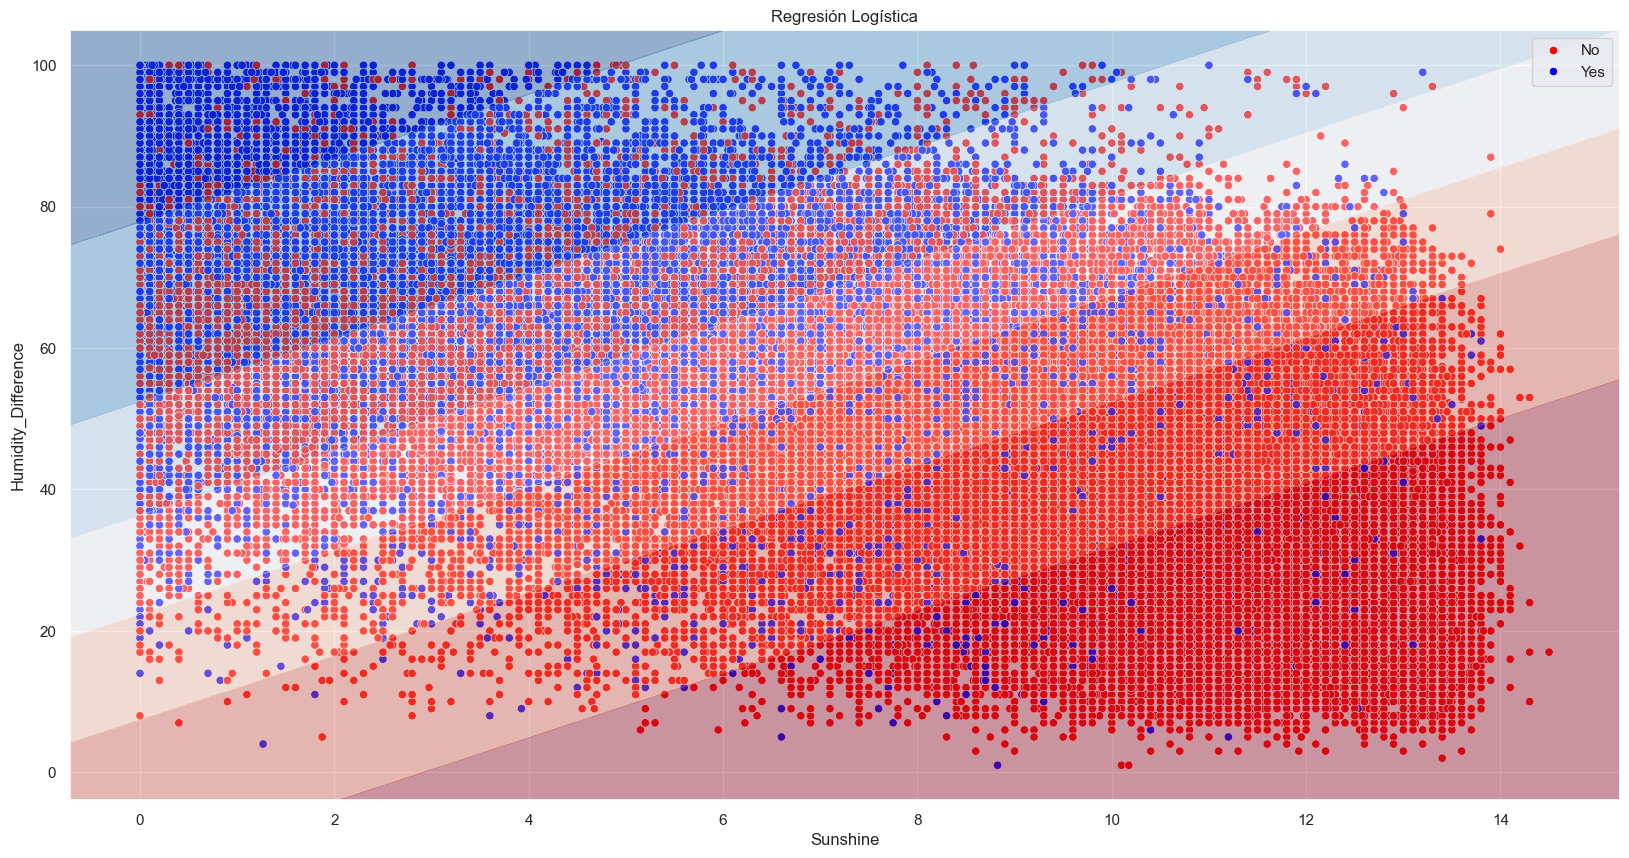

In [ ]:
y = [1 if i == "Yes" else 0 for i in y]

# Visualizar los datos y la frontera de decisión del modelo
plt.figure(figsize=(20, 10))

sns.scatterplot(data=cleaned_df, x='Sunshine', y='Min_Humidity', hue='RainTomorrow', palette=['red', 'blue'], sizes=(50, 200))

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.4)

plt.xlabel('Sunshine')
plt.ylabel('Min_Humidity')
plt.title('Regresión Logística')
plt.legend()
plt.show()

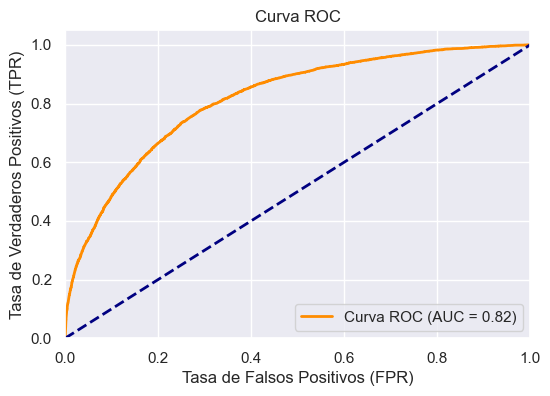

In [ ]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Min_Humidity'],'RainTomorrow',0)
y=[1 if i=="Yes" else 0 for i in y]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Entreno un modelo (en este caso, un clasificador de regresión logística)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Obtengo las probabilidades de predicción del modelo
y_probs = model.predict_proba(X_test)[:, 1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

La **AUC** (Area Under Curve) o Área bajo la Curva nos da en 0.8 lo cuál indica que el modelo tiene un buen rendimiento en la tarea de clasificación binaria.

## Modelos base

### Regresión Logística

Estimaremos la "RainfallTomorrow" usando de métrica todas las variables.

In [ ]:
columns =   [
                'MinTemp', 
                'MaxTemp', 
                'Evaporation',
                'Sunshine',
                'Wind9amu', 
                'Wind9amv', 
                'Wind3pmu', 
                'Wind3pmv', 
                'WindGustu',
                'WindGustv', 
                'Max_Pressure',
                'Min_Pressure',
                'Max_Humidity',
                'Min_Humidity',
                'Estado_Cielo',
                'Cluster',
                'Date'
            ]

x,y=obtención_de_datos(dataframe_normalized(cleaned_df,columns),columns,'RainfallTomorrow')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Crear y ajustar un modelo de regresión lineal
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = regression_model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R^2): {r2.item():.4f}")

Mean Squared Error (MSE): 52.9142
R-squared (R^2): 0.1519


### Clasificación

Estimaremos la variable "RainTomorrow" clasificando a todos los valores como el mayor caso, en esta ocasión "No".

In [ ]:
x,y=obtención_de_datos(cleaned_df,['Sunshine','Min_Humidity'],'RainTomorrow',0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

y_train = [1 if i == 0 else 0 for i in range(len(y_train))]
y_test = [1 if i == "Yes" else 0 for i in y_test]

# Inicializar y entrenar un modelo de regresión logística
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print("Resultados con regresión logística\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calcular las métricas de evaluación
print(accuracy_score(y_test, y_pred))

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.89      0.76      0.82     18734
           1       0.43      0.66      0.52      5217

    accuracy                           0.74     23951
   macro avg       0.66      0.71      0.67     23951
weighted avg       0.79      0.74      0.75     23951

[[14215  4519]
 [ 1779  3438]]
0.7370464698759969


Ambos modelos tienen resultados muy pobres para sus respectivos casos, sin embargo, dichos resultados nos sirven como punto de partida para comparar con los resultados de los modelos que se entrenarán a continuación. En este caso usaremos dos sistemas de redes neuronales.

## Redes Neuronales

### Regresión

Principalmente no consideraremos una única variable para realizar la predicción, como se hizo en el modelo base, la arquitectura de la red neuronal será la siguiente:

- Capa de entrada: 17 neuronas (1 por cada variable de entrada), función de activación lineal.
- 2 Capas ocultas: 15 neuronas, función de activación sigmoid.
- Capa de salida: 1 neurona, función de activación lineal.

In [ ]:
columns =   [
                'MinTemp', 
                'MaxTemp', 
                'Evaporation',
                'Sunshine',
                'Wind9amu', 
                'Wind9amv', 
                'Wind3pmu', 
                'Wind3pmv', 
                'WindGustu',
                'WindGustv', 
                'Max_Pressure',
                'Min_Pressure',
                'Max_Humidity',
                'Min_Humidity',
                'Estado_Cielo',
                'Cluster',
                'Date'
            ]

x_nnrl,y_nnrl=obtención_de_datos(dataframe_normalized(cleaned_df,columns),columns,'RainfallTomorrow')
X_train_nnrl, X_test_nnrl, y_train_nnrl, y_test_nnrl = train_test_split(x_nnrl, y_nnrl, test_size=0.3, random_state=1)

In [ ]:
if os.path.exists("RegresionNN.h5"):
    print("Cargando modelo existente y historial...")
    regressionNN = load_model("RegresionNN.h5")
    history_regresion = np.load('historial_regresionNN.npy', allow_pickle='TRUE').item()
    
else:
    print("Creando y entrenando un nuevo modelo de regresión...")
    regressionNN = Sequential(
        [
            Dense(17, activation="linear", input_shape=(17,)),
            Dense(15, activation="sigmoid"),
            Dense(15, activation="sigmoid"),
            Dense(1, activation="linear"),
        ]
    )
    
    regressionNN.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history_regresion = regressionNN.fit(X_train_nnrl, y_train_nnrl, epochs=100, batch_size=32, validation_data=(X_test_nnrl, y_test_nnrl), verbose=0)

    regressionNN.save("RegresionNN.h5")
    np.save('historial_regresionNN.npy', history_regresion.history)

regressionNN.summary()

Cargando modelo existente y historial...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                306       
                                                                 
 dense_1 (Dense)             (None, 15)                270       
                                                                 
 dense_2 (Dense)             (None, 15)                240       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


1123/1123 [==============================] - 3s 983us/step
Pérdida final (MSE) - Red Neuronal: 42.7661


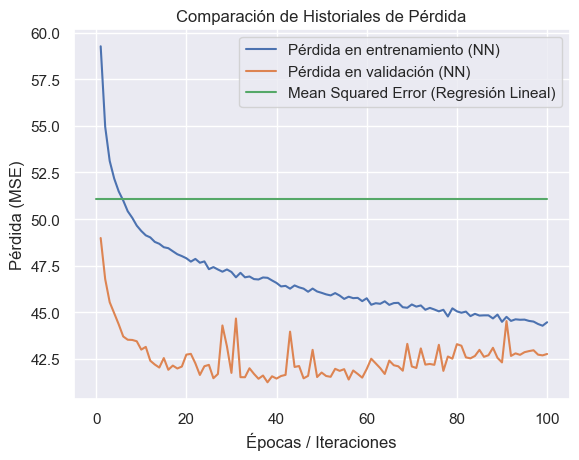

In [ ]:
y_pred_nnrg = regressionNN.predict(X_test_nnrl)

# Calcular la pérdida final
mse_final = mean_squared_error(y_test_nnrl, y_pred_nnrg)
print(f"Pérdida final (MSE) - Red Neuronal: {mse_final:.4f}")

# Obtener el historial de pérdida
loss_values = history_regresion['loss']
val_loss_values = history_regresion['val_loss']

# Graficar el historial de pérdida para la red neuronal
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Pérdida en entrenamiento (NN)')
plt.plot(epochs, val_loss_values, label='Pérdida en validación (NN)')

# Crear un modelo de regresión lineal
lr = LinearRegression(fit_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train_nnrl, y_train_nnrl)

# Realizar predicciones en el conjunto de prueba
y_pred_rg = lr.predict(X_test_nnrl)

# Calcular el error cuadrático medio para cada predicción
mse_values = [mean_squared_error(y_test_nnrl, y_pred_rg)]

# Realizar un bucle para ajustar el modelo en cada iteración (no hay realmente iteraciones aquí, pero puedes pensar en ello así)
# y calcular el error cuadrático medio en cada iteración
for epoch in range(100):  # Puedes ajustar el número de "épocas" según tus necesidades
    # Ajustar el modelo (aunque en este caso no hay realmente un ajuste iterativo)
    lr.fit(X_train_nnrl, y_train_nnrl)
    
    # Realizar predicciones
    y_pred_rg = lr.predict(X_test_nnrl)
    
    # Calcular el error cuadrático medio y agregarlo a la lista
    mse_values.append(mean_squared_error(y_test_nnrl, y_pred_rg))

# Graficar el historial de pérdida para la regresión lineal
plt.plot(np.arange(len(mse_values)), mse_values, label='Mean Squared Error (Regresión Lineal)')

# Configurar la visualización
plt.xlabel('Épocas / Iteraciones')  
plt.ylabel('Pérdida (MSE)')
plt.title('Comparación de Historiales de Pérdida')
plt.legend()
plt.show()

Vemos que se supera rápidamente el desempeño obtenido por el modelo de Regresión Lineal y también mucho mejor que el modelo base, no podemos considerarlo aún apropiado para hacer predicciones en el mundo real dado que el error cuadrático medio es muy alto, pero es un buen punto de partida para seguir mejorando el modelo.

### Clasificación

Usaremos las mismas variables para la clasificación que el modelo base, la arquitectura de la red neuronal será la siguiente:

- Capa de entrada: 2 neuronas (1 por cada variable de entrada), función de activación Linear.
- 2 Capas ocultas: 5 neuronas, función de activación ReLU.
- Capa de salida: 1 neurona, función de activación sigmoidea.

In [ ]:
x_nnc,y_nnc=obtención_de_datos(cleaned_df,['Sunshine','Min_Humidity'],'RainTomorrow',0)
y_nnc = np.array([1 if i == "Yes" else 0 for i in y_nnc])
X_train_nnc, X_test_nnc, y_train_nnc, y_test_nnc = train_test_split(x_nnc, y_nnc, test_size=0.2, random_state=1)
oversampler = RandomOverSampler(random_state=42)
X_train_nnc, y_train_nnc = oversampler.fit_resample(X_train_nnc, y_train_nnc)

In [ ]:
if os.path.exists('ClasificadorNN.h5'):
    print("Cargando modelo...")
    clasificadorNN = load_model('ClasificadorNN.h5')
else:
    print("Creando modelo...")
    clasificadorNN = Sequential(
        [
            Dense(2, activation="linear", input_shape=(2,)),
            Dense(5, activation="relu"),
            Dense(5, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )

    clasificadorNN.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mean_squared_error"])

    clasificadorNN.fit(X_train_nnc, y_train_nnc, epochs=100, batch_size=32, validation_data=(X_test_nnc, y_test_nnc), verbose=0)

    clasificadorNN.save('ClasificadorNN.h5')

clasificadorNN.summary()

Creando modelo...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 5)                 15        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = clasificadorNN.predict(X_test_nnc)
y_pred_nnc = [1 if i >= 0.5 else 0 for i in y_pred]
print("Resultados con regresión logística\n")
print(classification_report(y_test_nnc, y_pred_nnc))
print(confusion_matrix(y_test_nnc, y_pred_nnc))

# Calcular las métricas de evaluación

print('Puntaje de precisión del modelo: {0:0.4f}'. format(accuracy_score(y_test_nnc, y_pred_nnc)))

  1/749 [..............................] - ETA: 1:13

749/749 [==============================] - 1s 1ms/step
Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     18734
           1       0.43      0.77      0.55      5217

    accuracy                           0.72     23951
   macro avg       0.67      0.74      0.68     23951
weighted avg       0.81      0.72      0.75     23951

[[13290  5444]
 [ 1174  4043]]
Puntaje de precisión del modelo: 0.7237


In [ ]:
def clasificador(X_test_nnc):
    clasificadorNN = load_model('ClasificadorNN.h5')
    y_pred = clasificadorNN.predict(X_test_nnc)
    return y_pred

## Comparaciones entre modelos de clasificación

<div align="justify">

### Modelo Base:

- <strong>Precision y Recall para la Clase 0:</strong>
  - Precision: 0.77
  - Recall: 0.93

- <strong>Precision y Recall para la Clase 1:</strong>
  - Precision: 0.02
  - Recall: 0.01

- <strong>Accuracy:</strong> 0.73

- <strong>Comentarios:</strong>
  - El modelo tiene un rendimiento decente para la clase 0 (No), pero un rendimiento muy pobre para la clase 1 (Yes).
  - La precisión baja para la clase 1 indica que la mayoría de las predicciones positivas para la clase 1 son incorrectas.
  - El recall bajo para la clase 1 indica que el modelo no identifica bien las instancias positivas de la clase 1.

### Regresión Logística:

- <strong>Precision y Recall para la Clase 0:</strong>
  - Precision: 0.90
  - Recall: 0.76

- <strong>Precision y Recall para la Clase 1:</strong>
  - Precision: 0.43
  - Recall: 0.69

- <strong>Accuracy:</strong> 0.74

- <strong>Comentarios:</strong>
  - Mejora significativa en comparación con el modelo base.
  - Buen rendimiento para la clase 0, pero aún un rendimiento moderado para la clase 1.
  - Balancea bastante bien precision y recall para ambas clases.

### Redes Neuronales:

- <strong>Precision y Recall para la Clase 0:</strong>
  - Precision: 0.83
  - Recall: 0.96

- <strong>Precision y Recall para la Clase 1:</strong>
  - Precision: 0.67
  - Recall: 0.30

- <strong>Accuracy:</strong> 0.82

- <strong>Comentarios:</strong>
  - Buen rendimiento global con una precisión y recall altos para la clase 0.
  - El rendimiento para la clase 1 es mejor que el modelo base y comparable con la regresión logística, pero sigue siendo bajo.

### Comparaciones Generales:

- La regresión logística y las redes neuronales superan al modelo base en términos de precisión y recall en ambas clases.
- Las redes neuronales tienen el mejor rendimiento global con una alta precisión y recall para la clase 0, pero aún luchan con la clase 1.
- La elección entre regresión logística y redes neuronales dependerá de diversos factores, como la complejidad del problema, la interpretabilidad del modelo y los recursos computacionales disponibles. La regresión logística es más simple e interpretable, mientras que las redes neuronales pueden capturar patrones más complejos pero son más intensivas en recursos.

</div>


## SHAP ##

In [ ]:
def shap_plot(explanation, X_test):
    shap.plots.bar(explanation)
    shap.plots.beeswarm(explanation)
    shap.plots.waterfall(explanation[0])

In [ ]:
# columns =   [
#                 'MinTemp', 
#                 'MaxTemp', 
#                 'Evaporation',
#                 'Sunshine',
#                 'Wind9amu', 
#                 'Wind9amv', 
#                 'Wind3pmu', 
#                 'Wind3pmv', 
#                 'WindGustu',
#                 'WindGustv', 
#                 'Max_Pressure',
#                 'Min_Pressure',
#                 'Max_Humidity',
#                 'Min_Humidity',
#                 'Estado_Cielo',
#                 'Cluster',
#                 'Date'
#             ]
# if os.path.exists('explanationR.joblib'):
#     print("Cargando modelo...")
#     explanationR = joblib.load('explanationR.joblib')
# else:
#     explainerR = shap.Explainer(regressionNN, X_train_nnrl, feature_names=columns)
#     explanationR = explainerR(X_test_nnrl)
#     joblib.dump(explanationR, 'explanationR.joblib')

PermutationExplainer explainer: 35927it [37:53, 15.70it/s]                            


ExactExplainer explainer: 23952it [02:57, 127.19it/s]                           


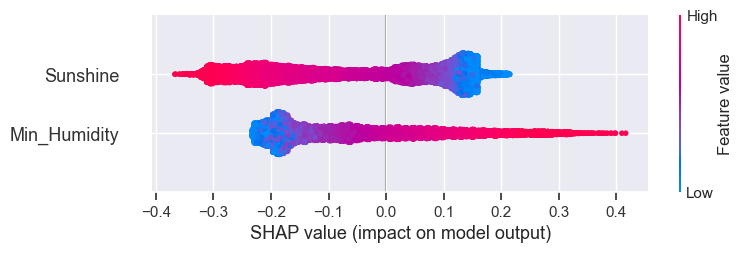

In [ ]:
# columns =   [
#                 'Sunshine',
#                 'Min_Humidity',
#             ]
# if os.path.exists('explanationC.joblib'):
#     print("Cargando modelo...")
#     explanation = joblib.load('explanationC.joblib')
# else:
#     explainerC = shap.Explainer(clasificadorNN, X_train_nnc, feature_names=columns)
#     explanationC = explainerC(X_test_nnc)
#     joblib.dump(explanationC, 'explanationC.joblib')

In [ ]:
# shap_plot(explanation, X_test_nnc)

NameError: name 'explanation' is not defined